# Modeling Antibiotic Responce Through Datamining in the MIMICIII Dataset
###Garrett Eickelberg with help from Kishore Anekalla, Yikuan Li, Dr. Yuan Luo, Dr. Nelson Sanchez-Pinto

In this study, all ICU stays associated with patients in the MIMIC-III dataset who were over the age of 16, received at least one dose of antibiotics within 96 hours after ICU admission and had a sterile site microbiological culture in the ICU within 24 hours of their first antibiotic dose were eligible for inclusion.

Additionally, as a sanity check, patients were required to have at least one peripheral oxygen saturation (SpO2) measurement in the 72-hour window after first antibiotic dose (t0:t0+72) (performed in 03.10-clinical_variables).

Patients with multiple hospital admission with ICU encounters meeting study criteria are analyzed independently; however, each patient’s ICU stays are assigned to the same train/test group (see Modeling).

Sterile site microbiological cultures (SSC) are defined as cultures obtained from any of the following: blood, joint, urine, CSF, pleural cavity, peritoneum, or bronchoalveolar lavage.

Antibiotics prescriptions were defined by the administration of any “antibacterial for systemic use” represented by Anatomical Therapeutic Chemical (ATC) code J01 (01-prescription_table).

the maximum length of cumulative antibiotic days following a SSC is calculated for each ICU encounter.

A total of 14,478 ICU encounters (11,987 unique patients) meet the inclusion criteria for this study and are allocated to one of four groups based on their SSC result (positive vs. negative) and the duration of their antibiotics (short [≤96 hours] vs. prolonged [>96 hours]).

Antibiotics in the prescription table have date rather than time resolution, so 96 hours was chosen to distinguish short vs. prolonged EAT rather than 72 hours used conventionally in the EAT literature to account for this uncertainty. 

Patients with positive SSC and prolonged antibiotics were considered true SBIs (prediction events), whereas those with negative cultures and short antibiotics were considered true non-SBIs (prediction non-events). Patients in the short antibiotics with positive SSC group (non-serious bacterial infections) and prolonged antibiotics with negative SSC groups (unknown SBI) are removed and will be further explored in future analyses (see Discussion and Fig. 5).

This leaves a total of 7,588 ICU encounters (6,824 patients) in the study (Table 1) that were further split into training and testing sets (see Modeling). 


## important note:

* this cohort_generation has been reworked on oct 15-17/2019. In the rework, lots of redundancies from past iterations were removed that opened up potential for errors. However, some functionality has been lost (namely the flexibility of the user to declare which parameters to base certain decisions off of. These flexibility features were origionally implemented in SSC_for_cohort(). Restoring these, will be readded in at a later date. Current parameters are setup for the old "default" SSC_for_cohort() options.

flexibility parameters to restore:

* blood_only: option to restrict to only blood cultures

<del>n_days, n_day_column: the number of days after t_0 where SSC's will be considered to assign a patient as having a positive or negative.
origionally the criteria was to find SSC cultures within a 3 days window of t_0 (first ab time) and t_0_sc (first ssc time), if any were pos then patient was culture pos, else negative.
we can sepcify column (n_day_column) and day window if we want to look from ICU_admit instead. [COMPLETED]

first_ssc_after_ICU: allows option to restrict the culture result output to only those after ICU admission. 
filter_t0_after_ICU: allows option to restrict the first antibiotic (t_0) to only those after ICU admission. 
n_filter_days: number of days allowed after ICU admit for an ab (t_0) to occur for patient to be considered, requires  filter_t0_after_ICU=True.  [ENABLED BY DEFAULT]

In [ ]:
#in this copy i will try to use my reimagined

In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 #used to connect to our local MIMIC-III database
import collections
# import getpass
from datetime import datetime as dt
import os,sys,re
from collections import Counter
#import seaborn as sns
# import random
from datetime import timedelta
from pathlib import Path
import importlib

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

time: 0 ns (started: 2023-07-24 12:11:09 +08:00)


# connecting to the Luo Lab's locally stored postgres database copy of the MIMIC-III database

In [2]:
# note, all server information is stored in a config.py file that is present in the .gitignore
import config 
conn = psycopg2.connect(dbname=config.dbname, user=config.user, host=config.host, port=config.port,password=config.password)
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciv" + ';'

time: 62 ms (started: 2023-07-24 12:11:10 +08:00)


In [3]:
os.getcwd()

'c:\\Users\\csfhe\\Documents\\RA\\mimiciii-antibiotics-opensource\\notebooks'

time: 0 ns (started: 2023-07-24 12:11:12 +08:00)


In [4]:
os.chdir(('c:\\Users\\csfhe\\Documents\\RA\\mimiciii-antibiotics-opensource\\notebooks'))

time: 0 ns (started: 2023-07-24 12:11:13 +08:00)


In [5]:
# # note, all server information is stored in a config.py file that is present in the .gitignore
# import importlib
# scriptName = 'config.py'
# script = importlib.import_module(wd+'/notebooks/PIPELINE/%s' % scriptName)

# #import config
# conn = psycopg2.connect(dbname=config.dbname, user=config.user, host=config.host, port=config.port,password=config.password)
# cur=conn.cursor()

# query_schema = 'SET search_path to ' + "mimiciii" + ';'

time: 0 ns (started: 2023-07-24 12:03:05 +08:00)


In [5]:
from parameters import ABrx, repository_path
#import parameters
os.chdir(repository_path)

ABrx.head(5)

#ABrx= ABrx
#del(parameters.ABrx)

ABrx.rename(index=str, columns={'Unnamed: 0':"ab_id", 
                                    'starttime':'ab_start',
                                    'stoptime':'ab_end'}, inplace=True)

time: 3.25 s (started: 2023-07-24 12:11:16 +08:00)


#### ##removing abrx rows where the ab occurs outside of the icu and or doesn't have a icustay_id

In [6]:
icustay = query_schema + """
SELECT icu.stay_id,
    icu.intime as ICU_admit,
    icu.outtime as ICU_disch, 
    hadm_id
FROM mimiciv_icu.icustays icu

"""
icustay_df = pd.read_sql_query(icustay,conn) #38637


C:\Users\csfhe\AppData\Local\Temp\ipykernel_9440\4085366913.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  icustay_df = pd.read_sql_query(icustay,conn) #38637


time: 328 ms (started: 2023-07-24 12:11:19 +08:00)


In [7]:
icustay_df

,stay_id,icu_admit,icu_disch,hadm_id
0,39553978,2180-07-23 14:00:00,2180-07-23 23:50:47,29079034
1,39765666,2189-06-27 08:42:00,2189-06-27 20:38:27,26913865
2,37067082,2157-11-20 19:18:02,2157-11-21 22:08:00,24597018
3,34592300,2157-12-19 15:42:24,2157-12-20 14:27:41,27703517
4,31205490,2110-04-11 15:52:22,2110-04-12 23:59:56,25563031
...,...,...,...,...
73176,32336619,2148-11-19 14:23:43,2148-11-26 13:12:15,26785317
73177,31070865,2139-10-10 19:18:00,2139-10-11 18:21:28,25304202
73178,36075953,2149-01-08 18:12:00,2149-01-10 13:11:02,25744818
73179,38978960,2164-09-12 09:26:28,2164-09-17 16:35:15,21033226


time: 16 ms (started: 2023-07-24 12:11:27 +08:00)


In [8]:
ABrx.head(10)

,ab_id,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,ab_start,ab_end,drug_type,...,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route,rxcui,Antibiotics
0,153,10418018,26872471,12683541,10418018-49,49.0,P48AWH,2160-11-23 16:00:00,2160-11-24 15:00:00,MAIN,...,1g Froz.Bag,NaN,1,g,1,BAG,1.0,IV,1665050.0,True
1,166,10418018,26872471,73754005,10418018-48,48.0,P48AWH,2160-11-24 16:00:00,2160-11-24 17:00:00,MAIN,...,500 mg Cap,NaN,500,mg,1,CAP,3.0,PO/NG,309114.0,True
2,202,10418096,23746160,51370446,10418096-54,54.0,P34GXB,2125-12-06 08:00:00,2125-12-07 00:00:00,MAIN,...,2 g / 100 mL Dextrose (iso-os),NaN,2,g,1,BAG,3.0,IV,1665060.0,True
3,231,10418126,27510878,18984545,10418126-65,65.0,P31MCV,2186-03-16 14:00:00,2186-03-17 13:00:00,MAIN,...,1g Froz.Bag,NaN,1,g,1,BAG,3.0,IV,1665050.0,True
4,232,10418126,27510878,29737578,10418126-86,86.0,P34GXB,2186-03-19 15:00:00,2186-03-19 20:00:00,MAIN,...,250 mg Cap,NaN,2000,mg,8,CAP,1.0,PO/NG,308182.0,True
5,274,10418253,28846946,13039982,10418253-237,237.0,P45MAB,2182-09-10 20:00:00,2182-09-12 19:00:00,MAIN,...,1g Frozen Bag,NaN,1000,mg,1,BAG,2.0,IV,1807508.0,True
6,320,10418253,28846946,65723854,10418253-301,301.0,P451D0,2182-09-15 10:00:00,2182-09-15 18:00:00,MAIN,...,500 mg Cap,NaN,500,mg,1,CAP,4.0,PO/NG,309114.0,True
7,324,10418253,28846946,69943922,10418253-235,235.0,P23H5V,2182-09-10 11:00:00,2182-09-11 18:00:00,MAIN,...,2g Duplex Bag,NaN,2,g,1,BAG,3.0,IV,1665060.0,True
8,388,10418336,26608910,10148151,10418336-438,438.0,P43QJ8,2136-09-21 20:00:00,2136-09-22 15:00:00,MAIN,...,500mg Tablet,NaN,500,mg,1,TAB,2.0,PO,617296.0,True
9,394,10418336,26608910,15568013,10418336-348,348.0,P17BTS,2136-09-16 08:00:00,2136-09-17 08:00:00,MAIN,...,400mg Premix Bag,NaN,400,mg,1,BAG,2.0,IV,1665212.0,True


time: 32 ms (started: 2023-07-24 12:11:30 +08:00)


In [ ]:
##removing abrx rows where the ab occurs outside of the icu and or doesn't have a icustay_id

#ABrx_ntnull= ABrx.loc[ABrx.loc[:,"icustay_id"].notnull(),:]
#ABrx_ntnull_icu=pd.merge(ABrx_ntnull,icustay_df, left_on='icustay_id', right_on='icustay_id' )


# crit1=pd.to_datetime((ABrx_ntnull_icu['ab_start'])).dt.date.between(
#     ABrx_ntnull_icu['icu_admit'].dt.date,ABrx_ntnull_icu['icu_disch'].dt.date)

# ABrx_ntnull_icu= ABrx_ntnull_icu[crit1]
# print(len(ABrx_ntnull_icu))

# #removing abrx where startdate>enddate
# crit2=pd.to_datetime(ABrx_ntnull_icu['ab_start']) <= pd.to_datetime(ABrx_ntnull_icu['ab_end'])
# ABrx_ntnull_icu= ABrx_ntnull_icu[crit2]
# print(len(ABrx_ntnull_icu))

In [ ]:
#exists starttime after the endtime
# ABrx_ntnull_icu1=pd.merge(ABrx,icustay_df, left_on='hadm_id', right_on='hadm_id' )

# crit2=pd.to_datetime(ABrx_ntnull_icu1['ab_start']) > pd.to_datetime(ABrx_ntnull_icu1['ab_end'])
# ABrx_ntnull_icu1= ABrx_ntnull_icu1[crit2]
# ABrx_ntnull_icu1.head(10)

In [9]:
##mimic-iv does not contain icustay_id, merge two table by using the hadm_id
ABrx_ntnull_icu=pd.merge(ABrx,icustay_df, left_on='hadm_id', right_on='hadm_id' )

crit1=pd.to_datetime((ABrx_ntnull_icu['ab_start'])).dt.date.between(
    ABrx_ntnull_icu['icu_admit'].dt.date,ABrx_ntnull_icu['icu_disch'].dt.date)

ABrx_ntnull_icu= ABrx_ntnull_icu[crit1]
print(len(ABrx_ntnull_icu))

#removing abrx where startdate>enddate
crit2=pd.to_datetime(ABrx_ntnull_icu['ab_start']) <= pd.to_datetime(ABrx_ntnull_icu['ab_end'])
ABrx_ntnull_icu= ABrx_ntnull_icu[crit2]
print(len(ABrx_ntnull_icu))

247012
227985
time: 1.36 s (started: 2023-07-24 12:11:35 +08:00)


# reimagining how to do this with a simple sql query: 10/10/19:
output: shows patient and icu_stay info associated with each SSC taken.

few benefits of this: 
* the years old is at time of the hadm_id and or icustay_id, rather than first admit age.
* query runs super fast and has less bloat
* can do all of the above with 1 sql script


rows: 440230 
hadm_id:35013
icustay_ids: 38395
subject_ids: 27315

-filtering to only SSC within -24hr icuadmit and +24hr icudisch:

rows:  267480
hadm_id:31345
icustay_ids: 33347
subject_ids: 24559

In [52]:
import random
random.seed(10)

time: 0 ns (started: 2023-07-24 12:20:35 +08:00)


In [226]:
#mimic iv pd does not have dob, but have patient age
#mimic iv icu does not have dbsource
#date_part('year',age(icu.intime, pd.dob)) as yearsold
sql_reimagined = query_schema + """
WITH subject_years
AS (
SELECT icu.stay_id,
    icu.subject_id,
	icu.hadm_id,
    pd.anchor_age as yearsold,
    icu.intime as ICU_admit, icu.outtime as ICU_disch, icu.los, --icu.FIRST_WARDID, icu.LAST_WARDID,
	pd.gender
FROM  mimiciv_icu.icustays icu
LEFT JOIN mimiciv_hosp.patients pd
    ON pd.subject_id = icu.subject_id
),
ssc 
AS(
	SELECT microevent_id as ssc_id, subject_id, hadm_id,spec_itemid, spec_type_desc, org_name,
	  (CASE WHEN charttime IS NULL THEN chartdate ELSE charttime END)as ssc_charttime
	FROM mimiciv_hosp.microbiologyevents
	WHERE NOT lower(spec_type_desc) = 'fluid received in blood culture bottles' 
	AND NOT lower(spec_type_desc) = 'blood bag fluid'
	AND (lower(spec_type_desc) LIKE '%blood%' 
	OR lower(spec_type_desc) LIKE '%joint%' 
	OR lower(spec_type_desc) LIKE '%urine%' 
	OR lower(spec_type_desc) LIKE  '%csf%'
	OR lower(spec_type_desc) LIKE '%spinal%'
	OR lower(spec_type_desc) LIKE '%pleural%'
	OR lower(spec_type_desc) LIKE '%peritoneal%'
	OR lower(spec_type_desc) LIKE '%bal%'
	OR lower(spec_type_desc) LIKE '%bronchoalveolar lavage%')
)

SELECT sy.*, ssc.spec_itemid, ssc.spec_type_desc, ssc.org_name, ssc.ssc_charttime, ssc.ssc_id
FROM subject_years sy
INNER JOIN ssc
	ON sy.hadm_id = ssc.hadm_id

"""

from parameters import cohort_age_cutoff

#cohort_age_cutoff = 16

sql_reimagined_16_df = pd.read_sql_query(sql_reimagined,conn) #38637

# #restricts to only patients who are 16 yo or older at time of icuadmit.
sql_reimagined_16_df= sql_reimagined_16_df.loc[sql_reimagined_16_df.loc[:,'yearsold']>=cohort_age_cutoff,:] #cohort_age_cutoff = 16 by default

# #restricts to only ssc that occur within icu_admit-24hr and icu_disch+24 hour
SSC_icu_window_criteria= pd.to_datetime((sql_reimagined_16_df['ssc_charttime'])).between(
    sql_reimagined_16_df['icu_admit']- pd.DateOffset(1),
    sql_reimagined_16_df['icu_disch']+ pd.DateOffset(1))

sql_reimagined_16_df=sql_reimagined_16_df[SSC_icu_window_criteria]


C:\Users\csfhe\AppData\Local\Temp\ipykernel_9440\3104999908.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_reimagined_16_df = pd.read_sql_query(sql_reimagined,conn) #38637


time: 8.91 s (started: 2023-07-24 12:50:15 +08:00)


In [214]:
from parameters import blood_only
if blood_only == True:
    sql_reimagined_16_df=(
        sql_reimagined_16_df.loc[sql_reimagined_16_df.loc[:,'spec_type_desc']
                                 .isin(["BLOOD CULTURE",
                                        'BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)'])
                                 ,:])

time: 0 ns (started: 2023-07-24 12:47:02 +08:00)


In [227]:
sql_reimagined_16_df.sort_values('ssc_id', ascending=True)

,stay_id,subject_id,hadm_id,yearsold,icu_admit,icu_disch,los,gender,spec_itemid,spec_type_desc,org_name,ssc_charttime,ssc_id
670,37510196,10001884,26184834,68,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,F,70079,URINE,None,2131-01-10 16:36:00,635
671,37510196,10001884,26184834,68,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,F,70081,URINE,None,2131-01-11 11:13:00,640
672,37510196,10001884,26184834,68,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,F,70079,URINE,None,2131-01-13 15:50:00,641
673,37510196,10001884,26184834,68,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,F,70012,BLOOD CULTURE,None,2131-01-13 16:00:00,642
674,37510196,10001884,26184834,68,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,F,70012,BLOOD CULTURE,None,2131-01-14 03:08:00,643
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497876,36195440,19999987,23865745,57,2145-11-02 22:59:00,2145-11-04 21:29:30,1.937847,F,70079,URINE,KLEBSIELLA PNEUMONIAE,2145-11-04 10:40:00,3228706
497877,36195440,19999987,23865745,57,2145-11-02 22:59:00,2145-11-04 21:29:30,1.937847,F,70079,URINE,KLEBSIELLA PNEUMONIAE,2145-11-04 10:40:00,3228707
497878,36195440,19999987,23865745,57,2145-11-02 22:59:00,2145-11-04 21:29:30,1.937847,F,70079,URINE,KLEBSIELLA PNEUMONIAE,2145-11-04 10:40:00,3228708
497879,36195440,19999987,23865745,57,2145-11-02 22:59:00,2145-11-04 21:29:30,1.937847,F,70012,BLOOD CULTURE,None,2145-11-05 10:35:00,3228709


time: 63 ms (started: 2023-07-24 12:50:24 +08:00)


In [228]:
#icu patients who older than 16, blood only
len(sql_reimagined_16_df)

263722

time: 0 ns (started: 2023-07-24 12:50:45 +08:00)


In [229]:
#restricts to only ssc that occur within icu_admit-24hr and icu_disch+24 hour
SSC_icu_window_criteria= pd.to_datetime((sql_reimagined_16_df['ssc_charttime'])).between(
    sql_reimagined_16_df['icu_admit']- pd.DateOffset(1),
    sql_reimagined_16_df['icu_disch']+ pd.DateOffset(1))

sql_reimagined_16_df=sql_reimagined_16_df[SSC_icu_window_criteria]

time: 78 ms (started: 2023-07-24 12:50:48 +08:00)


In [18]:
sql_reimagined_16_df=sql_reimagined_16_df[SSC_icu_window_criteria]

time: 16 ms (started: 2023-07-24 12:13:15 +08:00)


In [210]:
sql_reimagined_16_df.iloc[:4]

,stay_id,subject_id,hadm_id,yearsold,icu_admit,icu_disch,los,gender,spec_itemid,spec_type_desc,org_name,ssc_charttime,ssc_id
0,39959884,10014610,23258342,66,2173-12-20 09:55:34,2173-12-24 06:12:53,3.845359,M,70079,URINE,None,2173-12-19 14:02:00,5037
1,34926754,10014610,20579647,66,2174-05-30 23:14:49,2174-05-31 13:03:11,0.575255,M,70012,BLOOD CULTURE,ENTEROCOCCUS FAECALIS,2174-05-27 05:15:00,5060
2,34926754,10014610,20579647,66,2174-05-30 23:14:49,2174-05-31 13:03:11,0.575255,M,70012,BLOOD CULTURE,None,2174-05-27 05:15:00,5061
3,34926754,10014610,20579647,66,2174-05-30 23:14:49,2174-05-31 13:03:11,0.575255,M,70012,BLOOD CULTURE,None,2174-05-27 05:15:00,5062


time: 16 ms (started: 2023-07-24 12:45:10 +08:00)


In [207]:
sql_reimagined_16_df.head(5)

,stay_id,subject_id,hadm_id,yearsold,icu_admit,icu_disch,los,gender,spec_itemid,spec_type_desc,org_name,ssc_charttime,ssc_id
0,39959884,10014610,23258342,66,2173-12-20 09:55:34,2173-12-24 06:12:53,3.845359,M,70079,URINE,None,2173-12-19 14:02:00,5037
1,34926754,10014610,20579647,66,2174-05-30 23:14:49,2174-05-31 13:03:11,0.575255,M,70012,BLOOD CULTURE,ENTEROCOCCUS FAECALIS,2174-05-27 05:15:00,5060
2,34926754,10014610,20579647,66,2174-05-30 23:14:49,2174-05-31 13:03:11,0.575255,M,70012,BLOOD CULTURE,None,2174-05-27 05:15:00,5061
3,34926754,10014610,20579647,66,2174-05-30 23:14:49,2174-05-31 13:03:11,0.575255,M,70012,BLOOD CULTURE,None,2174-05-27 05:15:00,5062
4,34926754,10014610,20579647,66,2174-05-30 23:14:49,2174-05-31 13:03:11,0.575255,M,70012,BLOOD CULTURE,ENTEROCOCCUS FAECALIS,2174-05-27 10:25:00,5063


time: 0 ns (started: 2023-07-24 12:44:12 +08:00)


In [230]:
sql_reimagined_16_df.loc[sql_reimagined_16_df['yearsold']== 88]

,stay_id,subject_id,hadm_id,yearsold,icu_admit,icu_disch,los,gender,spec_itemid,spec_type_desc,org_name,ssc_charttime,ssc_id
0,30888848,10006277,25610553,88,2176-06-07 23:56:15,2176-06-08 20:47:56,0.869225,M,70079,URINE,ENTEROCOCCUS SP.,2176-06-09 01:11:00,2513
1,30888848,10006277,25610553,88,2176-06-07 23:56:15,2176-06-08 20:47:56,0.869225,M,70079,URINE,ENTEROCOCCUS SP.,2176-06-09 01:11:00,2514
2,30888848,10006277,25610553,88,2176-06-07 23:56:15,2176-06-08 20:47:56,0.869225,M,70079,URINE,ENTEROCOCCUS SP.,2176-06-09 01:11:00,2515
3,30888848,10006277,25610553,88,2176-06-07 23:56:15,2176-06-08 20:47:56,0.869225,M,70079,URINE,ENTEROCOCCUS SP.,2176-06-09 01:11:00,2516
4,30888848,10006277,25610553,88,2176-06-07 23:56:15,2176-06-08 20:47:56,0.869225,M,70079,URINE,ENTEROCOCCUS SP.,2176-06-09 01:11:00,2517
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492440,35617945,19899642,27603399,88,2127-07-01 04:21:55,2127-07-03 14:17:24,2.413530,M,70079,URINE,None,2127-07-01 07:30:00,3195070
492441,35617945,19899642,27603399,88,2127-07-01 04:21:55,2127-07-03 14:17:24,2.413530,M,70081,URINE,None,2127-07-01 07:30:00,3195071
492442,35617945,19899642,27603399,88,2127-07-01 04:21:55,2127-07-03 14:17:24,2.413530,M,70012,BLOOD CULTURE,None,2127-07-01 08:00:00,3195072
494863,37670531,19943755,20982130,88,2179-10-09 00:35:16,2179-10-09 18:12:10,0.733958,F,70012,BLOOD CULTURE,None,2179-10-08 19:50:00,3211191


time: 15 ms (started: 2023-07-24 12:51:01 +08:00)


In [149]:
sql_reimagined_16_df.head(5)

,stay_id,subject_id,hadm_id,yearsold,icu_admit,icu_disch,los,gender,spec_itemid,spec_type_desc,org_name,ssc_charttime,ssc_id
14,37510196,10001884,26184834,68,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,F,70079,URINE,None,2131-01-10 16:36:00,635
15,37510196,10001884,26184834,68,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,F,70081,URINE,None,2131-01-11 11:13:00,640
16,37510196,10001884,26184834,68,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,F,70079,URINE,None,2131-01-13 15:50:00,641
17,37510196,10001884,26184834,68,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,F,70012,BLOOD CULTURE,None,2131-01-13 16:00:00,642
18,37510196,10001884,26184834,68,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,F,70012,BLOOD CULTURE,None,2131-01-14 03:08:00,643


time: 0 ns (started: 2023-07-24 11:25:37 +08:00)


In [231]:
print(
len(sql_reimagined_16_df), 
len(sql_reimagined_16_df['hadm_id'].unique()),  
len(sql_reimagined_16_df['stay_id'].unique()),
len(sql_reimagined_16_df['subject_id'].unique())
)

263722 34889 38374 28410
time: 15 ms (started: 2023-07-24 12:51:08 +08:00)


# building patient list from PRESCRIPTION table

#### trying to redo this more simply --start

In [337]:
##making ssc list and ABrx list that have dates, unique identifier to tie back to origional table, and icustay_id's

ssc_join= sql_reimagined_16_df[['stay_id', 'ssc_charttime','ssc_id','icu_admit']].copy()
ssc_join=ssc_join.sort_values(['ssc_id','stay_id','ssc_charttime']).drop_duplicates(['stay_id','ssc_charttime']) 

ABrx_join= ABrx_ntnull_icu[['ab_id','stay_id','ab_start','ab_end']].copy()#.head(5)
ABrx_join=ABrx_join.sort_values(['ab_id','stay_id','ab_start']).drop_duplicates(['stay_id','ab_start','ab_end']) 


time: 735 ms (started: 2023-07-24 16:22:48 +08:00)


In [338]:
#cartesian product of unique ab-key: ['icustay_id','ab_start','enddate'] and ssc key-['icustay_id','ssc_charttime']
ssc_ab= pd.merge(
    ssc_join,
    ABrx_join, #removed row_id, may need to add back
    left_on= 'stay_id',
    right_on='stay_id',
    how = 'inner')

time: 141 ms (started: 2023-07-24 16:22:49 +08:00)


In [339]:
ssc_ab.head(5)

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end
0,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800398,2131-01-14 20:00:00,2131-01-16 07:00:00
1,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800400,2131-01-12 11:00:00,2131-01-18 11:00:00
2,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800407,2131-01-11 10:00:00,2131-01-12 10:00:00
3,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00
4,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800452,2131-01-11 08:00:00,2131-01-12 10:00:00


time: 0 ns (started: 2023-07-24 16:22:51 +08:00)


In [340]:
#- pd.to_datetime(pd.to_datetime(ssc_ab['ssc_charttime']).dt.date)
from parameters import round_SSC_to_date

if round_SSC_to_date==True:
    ssc_ab['ab_ssc_delta'] = (
        pd.to_datetime(ssc_ab['ab_start']) 
        - pd.to_datetime(ssc_ab['ssc_charttime'])
    )
else:
    ssc_ab['ab_ssc_delta'] = (
        pd.to_datetime(ssc_ab['ab_start']) 
        - pd.to_datetime(ssc_ab['ssc_charttime'])
    )    

lessthan24hr= abs(ssc_ab['ab_ssc_delta'])<='24:00:00'

#df of all rows where delta between the AB ab_start and ssc_charttime is <= 24hr
ssc_ab_24= ssc_ab.loc[lessthan24hr].copy()

time: 453 ms (started: 2023-07-24 16:22:53 +08:00)


In [341]:
ssc_ab['ab_ssc_delta'].head(10)

0     4 days 03:24:00
1     1 days 18:24:00
2     0 days 17:24:00
3     0 days 15:24:00
4     0 days 15:24:00
5     1 days 03:24:00
6     0 days 15:24:00
7     3 days 08:47:00
8     0 days 23:47:00
9   -1 days +22:47:00
Name: ab_ssc_delta, dtype: timedelta64[ns]

time: 0 ns (started: 2023-07-24 16:22:56 +08:00)


In [342]:
abs(ssc_ab['ab_ssc_delta']).head(10)

0   4 days 03:24:00
1   1 days 18:24:00
2   0 days 17:24:00
3   0 days 15:24:00
4   0 days 15:24:00
5   1 days 03:24:00
6   0 days 15:24:00
7   3 days 08:47:00
8   0 days 23:47:00
9   0 days 01:13:00
Name: ab_ssc_delta, dtype: timedelta64[ns]

time: 16 ms (started: 2023-07-24 16:22:58 +08:00)


In [343]:
ssc_ab_24.head(10)

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta
2,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800407,2131-01-11 10:00:00,2131-01-12 10:00:00,0 days 17:24:00
3,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,0 days 15:24:00
4,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800452,2131-01-11 08:00:00,2131-01-12 10:00:00,0 days 15:24:00
6,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800496,2131-01-11 08:00:00,2131-01-11 09:00:00,0 days 15:24:00
8,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800400,2131-01-12 11:00:00,2131-01-18 11:00:00,0 days 23:47:00
9,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800407,2131-01-11 10:00:00,2131-01-12 10:00:00,-1 days +22:47:00
10,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,-1 days +20:47:00
11,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800452,2131-01-11 08:00:00,2131-01-12 10:00:00,-1 days +20:47:00
12,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800458,2131-01-11 20:00:00,2131-01-12 10:00:00,0 days 08:47:00
13,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800496,2131-01-11 08:00:00,2131-01-11 09:00:00,-1 days +20:47:00


time: 0 ns (started: 2023-07-24 16:22:59 +08:00)


Why should we filtering only t_0?

In [344]:
#filtering only t_0 that are within n_filter_days of icu_admit. this eliminates potential for secondary infections being included
n_filter_days = 4
ssc_ab_24= ssc_ab_24[pd.to_datetime(ssc_ab_24['ab_start']).between(pd.to_datetime(pd.to_datetime(ssc_ab_24['icu_admit']).dt.date), 
                                                                   pd.to_datetime(ssc_ab_24['icu_admit'])+pd.DateOffset(n_filter_days))]

time: 375 ms (started: 2023-07-24 16:23:03 +08:00)


In [345]:
pd.to_datetime(pd.to_datetime(ssc_ab_24['icu_admit']).dt.date)

2         2131-01-11
3         2131-01-11
4         2131-01-11
6         2131-01-11
8         2131-01-11
             ...    
1134678   2164-09-12
1134679   2164-09-12
1134695   2145-11-02
1134696   2145-11-02
1134697   2145-11-02
Name: icu_admit, Length: 221037, dtype: datetime64[ns]

time: 140 ms (started: 2023-07-24 16:23:04 +08:00)


In [346]:
ssc_ab_24

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta
2,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800407,2131-01-11 10:00:00,2131-01-12 10:00:00,0 days 17:24:00
3,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,0 days 15:24:00
4,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800452,2131-01-11 08:00:00,2131-01-12 10:00:00,0 days 15:24:00
6,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800496,2131-01-11 08:00:00,2131-01-11 09:00:00,0 days 15:24:00
8,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800400,2131-01-12 11:00:00,2131-01-18 11:00:00,0 days 23:47:00
...,...,...,...,...,...,...,...,...
1134678,38978960,2164-09-12 13:39:00,3228673,2164-09-12 09:26:28,14798335,2164-09-12 23:00:00,2164-09-13 11:00:00,0 days 09:21:00
1134679,38978960,2164-09-12 13:39:00,3228673,2164-09-12 09:26:28,14798343,2164-09-12 23:00:00,2164-09-13 08:00:00,0 days 09:21:00
1134695,36195440,2145-11-04 10:40:00,3228697,2145-11-02 22:59:00,14798460,2145-11-04 23:00:00,2145-11-05 09:00:00,0 days 12:20:00
1134696,36195440,2145-11-05 10:35:00,3228709,2145-11-02 22:59:00,14798460,2145-11-04 23:00:00,2145-11-05 09:00:00,-1 days +12:25:00


time: 16 ms (started: 2023-07-24 16:23:06 +08:00)


In [347]:
#find the earlist ab start time
ssc_ab_24['t_0']= ssc_ab_24.groupby('stay_id')['ab_start'].transform(lambda x: min(x))
#ssc_ab_24_admitfilter['t_0']= ssc_ab_24_admitfilter.groupby('icustay_id')['ab_start'].transform(lambda x: min(x))

time: 3.08 s (started: 2023-07-24 16:23:10 +08:00)


In [348]:
###filtering out all AB_id that don't correspond to the t_0 ab (ie the first ab to meet criteria)

#annotating t_end: the latest enddate of the t_0 ab
ssc_ab_24_t0= ssc_ab_24[
    ssc_ab_24['ab_start']==ssc_ab_24['t_0']].copy() #.sort_values(['icustay_id','ab_end'], ascending=[True,False])#.drop_duplicates('icustay_id').copy()

ssc_ab_24_t0['t_end']= ssc_ab_24_t0.groupby('stay_id')['ab_end'].transform(lambda x: max(x))
# ssc_ab_24_t0['t_end']= ssc_ab_24_t0.groupby('stay_id')['ab_end'].transform(lambda x: max(pd.to_datetime(x).dt.date))


### not filtering to only the AB_id's that correspond to ab_start=t_0 and ab_end = t_end
    

time: 2.66 s (started: 2023-07-24 16:23:15 +08:00)


In [349]:
ssc_ab_24_t0

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end
3,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00
4,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800452,2131-01-11 08:00:00,2131-01-12 10:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00
6,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800496,2131-01-11 08:00:00,2131-01-11 09:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00
10,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,-1 days +20:47:00,2131-01-11 08:00:00,2131-01-20 12:00:00
11,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800452,2131-01-11 08:00:00,2131-01-12 10:00:00,-1 days +20:47:00,2131-01-11 08:00:00,2131-01-20 12:00:00
...,...,...,...,...,...,...,...,...,...,...
1134672,36075953,2149-01-09 03:13:00,3228662,2149-01-08 18:12:00,14798195,2149-01-08 20:00:00,2149-01-09 16:00:00,-1 days +16:47:00,2149-01-08 20:00:00,2149-01-14 08:00:00
1134673,38978960,2164-09-12 13:39:00,3228673,2164-09-12 09:26:28,14798283,2164-09-12 20:00:00,2164-09-16 12:00:00,0 days 06:21:00,2164-09-12 20:00:00,2164-09-16 12:00:00
1134695,36195440,2145-11-04 10:40:00,3228697,2145-11-02 22:59:00,14798460,2145-11-04 23:00:00,2145-11-05 09:00:00,0 days 12:20:00,2145-11-04 23:00:00,2145-11-05 09:00:00
1134696,36195440,2145-11-05 10:35:00,3228709,2145-11-02 22:59:00,14798460,2145-11-04 23:00:00,2145-11-05 09:00:00,-1 days +12:25:00,2145-11-04 23:00:00,2145-11-05 09:00:00


time: 16 ms (started: 2023-07-24 16:23:20 +08:00)


In [361]:
# find the ab that has the longest duration
ssc_ab_24_t0_tend = ssc_ab_24_t0[
    pd.to_datetime(ssc_ab_24_t0['ab_end'])==pd.to_datetime(ssc_ab_24_t0['t_end'])].copy()

# ssc_ab_24_t0_tend = ssc_ab_24_t0[
#     pd.to_datetime(ssc_ab_24_t0['ab_end']).dt.date==pd.to_datetime(ssc_ab_24_t0['t_end']).dt.date].copy()

time: 125 ms (started: 2023-07-24 16:30:04 +08:00)


In [362]:
#test
print(len(ssc_ab_24_t0_tend))

#removing ab where startdate>enddate
crit3=pd.to_datetime(ssc_ab_24_t0_tend['ab_end']) == pd.to_datetime(ssc_ab_24_t0_tend['t_end'])
#crit3=pd.to_datetime(ssc_t0ab_t0ssc['t_0']) <= pd.to_datetime(ssc_t0ab_t0ssc['ab_start'])
ssc_ab_24_t0_tend2= ssc_ab_24_t0_tend[crit3]
print(len(ssc_ab_24_t0_tend2))

54808
54808
time: 94 ms (started: 2023-07-24 16:30:10 +08:00)


In [363]:
#ab is unqiue but ssc is not
ssc_ab_24_t0_tend

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end
3,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00
10,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,-1 days +20:47:00,2131-01-11 08:00:00,2131-01-20 12:00:00
35,33685454,2129-08-05 15:54:00,796,2129-08-04 12:45:00,14801473,2129-08-05 14:00:00,2129-08-10 13:00:00,-1 days +22:06:00,2129-08-05 14:00:00,2129-08-10 13:00:00
40,31090461,2130-09-25 11:04:00,822,2130-09-24 00:50:00,14801575,2130-09-25 11:00:00,2130-09-26 11:00:00,-1 days +23:56:00,2130-09-25 11:00:00,2130-09-26 11:00:00
42,32358465,2131-03-10 00:58:00,828,2131-03-09 21:33:00,14801420,2131-03-10 01:00:00,2131-03-10 14:00:00,0 days 00:02:00,2131-03-10 01:00:00,2131-03-10 14:00:00
...,...,...,...,...,...,...,...,...,...,...
1134670,36075953,2149-01-09 03:13:00,3228662,2149-01-08 18:12:00,14798102,2149-01-08 20:00:00,2149-01-14 08:00:00,-1 days +16:47:00,2149-01-08 20:00:00,2149-01-14 08:00:00
1134673,38978960,2164-09-12 13:39:00,3228673,2164-09-12 09:26:28,14798283,2164-09-12 20:00:00,2164-09-16 12:00:00,0 days 06:21:00,2164-09-12 20:00:00,2164-09-16 12:00:00
1134695,36195440,2145-11-04 10:40:00,3228697,2145-11-02 22:59:00,14798460,2145-11-04 23:00:00,2145-11-05 09:00:00,0 days 12:20:00,2145-11-04 23:00:00,2145-11-05 09:00:00
1134696,36195440,2145-11-05 10:35:00,3228709,2145-11-02 22:59:00,14798460,2145-11-04 23:00:00,2145-11-05 09:00:00,-1 days +12:25:00,2145-11-04 23:00:00,2145-11-05 09:00:00


time: 16 ms (started: 2023-07-24 16:30:17 +08:00)


In [364]:
print(
    len(ssc_ab),
    len(ssc_ab_24),
    len(ssc_ab_24_t0),
    len(ssc_ab_24_t0_tend)
)

1134698 221037 68244 54808
time: 0 ns (started: 2023-07-24 16:30:20 +08:00)


In [365]:
ssc_ab_24_t0.head()

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end
3,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00
4,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800452,2131-01-11 08:00:00,2131-01-12 10:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00
6,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800496,2131-01-11 08:00:00,2131-01-11 09:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00
10,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,-1 days +20:47:00,2131-01-11 08:00:00,2131-01-20 12:00:00
11,37510196,2131-01-11 11:13:00,640,2131-01-11 04:20:05,14800452,2131-01-11 08:00:00,2131-01-12 10:00:00,-1 days +20:47:00,2131-01-11 08:00:00,2131-01-20 12:00:00


time: 15 ms (started: 2023-07-24 16:30:24 +08:00)


In [366]:
# how many ssc are associated with each t_0 meeting ab on average?:
ssc_ab_24_t0_tend.groupby('stay_id')['ssc_id'].nunique().describe()

count    27220.000000
mean         2.013519
std          1.170077
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: ssc_id, dtype: float64

time: 16 ms (started: 2023-07-24 16:30:26 +08:00)


In [367]:
### idea, just filter ssc_ab_24_t0 to the first ssc_charttime to find t_0_ssc
ssc_ab_24_t0_tend['t_0_sc']= ssc_ab_24_t0_tend.groupby('stay_id')['ssc_charttime'].transform(lambda x: min(x))

time: 5.95 s (started: 2023-07-24 16:30:29 +08:00)


In [368]:
### now filtering to (should_be) one row /icustay annotating t_0, t_end, and t_0_ssc
ssc_t0ab_t0ssc= ssc_ab_24_t0_tend[
    ssc_ab_24_t0_tend['ssc_charttime']==ssc_ab_24_t0_tend['t_0_sc']].copy()

time: 15 ms (started: 2023-07-24 16:30:35 +08:00)


In [369]:
print(
len(ssc_t0ab_t0ssc),
    ssc_t0ab_t0ssc['stay_id'].nunique()
)


27220 27220
time: 0 ns (started: 2023-07-24 16:30:35 +08:00)


In [370]:
ssc_t0ab_t0ssc.head()

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,t_0_sc
3,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00,2131-01-10 16:36:00
35,33685454,2129-08-05 15:54:00,796,2129-08-04 12:45:00,14801473,2129-08-05 14:00:00,2129-08-10 13:00:00,-1 days +22:06:00,2129-08-05 14:00:00,2129-08-10 13:00:00,2129-08-05 15:54:00
40,31090461,2130-09-25 11:04:00,822,2130-09-24 00:50:00,14801575,2130-09-25 11:00:00,2130-09-26 11:00:00,-1 days +23:56:00,2130-09-25 11:00:00,2130-09-26 11:00:00,2130-09-25 11:04:00
42,32358465,2131-03-10 00:58:00,828,2131-03-09 21:33:00,14801420,2131-03-10 01:00:00,2131-03-10 14:00:00,0 days 00:02:00,2131-03-10 01:00:00,2131-03-10 14:00:00,2131-03-10 00:58:00
53,38875437,2156-04-19 16:28:00,893,2156-04-19 18:11:19,14802091,2156-04-20 12:00:00,2156-04-21 11:00:00,0 days 19:32:00,2156-04-20 12:00:00,2156-04-21 11:00:00,2156-04-19 16:28:00


time: 16 ms (started: 2023-07-24 16:30:37 +08:00)


In [371]:
#test
print(len(ssc_t0ab_t0ssc))

#removing ab where startdate>enddate
crit3=pd.to_datetime(ssc_t0ab_t0ssc['ab_start']) <= pd.to_datetime(ssc_t0ab_t0ssc['t_end'])
#crit3=pd.to_datetime(ssc_t0ab_t0ssc['t_0']) <= pd.to_datetime(ssc_t0ab_t0ssc['ab_start'])
ssc_t0ab_t0ssc2= ssc_t0ab_t0ssc[crit3]
print(len(ssc_t0ab_t0ssc2))

27220
27220
time: 47 ms (started: 2023-07-24 16:30:42 +08:00)


# next: 2)	Count consecutive AB_therapy days for icustay’s in ssc_t0ab_t0ssc and ab associated with t_0/t_end. 
* method: i)	ABrx_ntnull_cohort= filter ABrx_ntnull_icu to the icustay in ssc_t0ab_t0ssc and count consecutive ab_therapy_days
* filter ABrx_ntnull_cohort to rows where startdate >= t_0

In [372]:
ABrx_ntnull_cohort= ABrx_ntnull_icu[ABrx_ntnull_icu['stay_id'].isin(ssc_t0ab_t0ssc['stay_id'].unique())] #114328

time: 47 ms (started: 2023-07-24 16:30:46 +08:00)


In [373]:
ABrx_ntnull_cohort= pd.merge(
        ABrx_ntnull_icu[ABrx_ntnull_icu['stay_id'].isin(ssc_t0ab_t0ssc['stay_id'].to_list())], ##filter ABrx_ntnull_icu to the icustay in ssc_t0ab_t0ssc and count consecutive ab_therapy_days
         ssc_t0ab_t0ssc[['stay_id','t_0','t_end','t_0_sc']],
         left_on='stay_id',
         right_on='stay_id',
         how='inner')  #114328 rows

# filter ABrx_ntnull_cohort to rows where startdate >= t_0
ABrx_ntnull_cohort= ABrx_ntnull_cohort[ABrx_ntnull_cohort['ab_start']>= ABrx_ntnull_cohort['t_0']]
ABrx_ntnull_cohort['t_end_consec']= ABrx_ntnull_cohort['t_end']

time: 219 ms (started: 2023-07-24 16:30:48 +08:00)


In [374]:
#test
print(len(ABrx_ntnull_cohort))

#removing abrx where startdate>enddate
crit4=pd.to_datetime(ABrx_ntnull_cohort['t_0']) <= pd.to_datetime(ABrx_ntnull_cohort['t_end'])
#crit4=pd.to_datetime(ABrx_ntnull_cohort['t_0']) <= pd.to_datetime(ABrx_ntnull_cohort['t_end_consec'])
#crit4=pd.to_datetime(ABrx_ntnull_cohort['ab_start']) <= pd.to_datetime(ABrx_ntnull_cohort['ab_end'])
ABrx_ntnull_cohort2= ABrx_ntnull_cohort[crit4]
print(len(ABrx_ntnull_cohort2))

156989
156989
time: 235 ms (started: 2023-07-24 16:30:50 +08:00)


In [375]:
#test
print(len(ABrx_ntnull_cohort2))

#removing abrx where startdate>enddate
crit5=pd.to_datetime(ABrx_ntnull_cohort['t_0']) <= pd.to_datetime(ABrx_ntnull_cohort['t_end_consec'])
#crit4=pd.to_datetime(ABrx_ntnull_cohort['ab_start']) <= pd.to_datetime(ABrx_ntnull_cohort['ab_end'])
ABrx_ntnull_cohort3= ABrx_ntnull_cohort2[crit5]
print(len(ABrx_ntnull_cohort3))

156989
156989
time: 141 ms (started: 2023-07-24 16:30:53 +08:00)


In [376]:
ABrx_ntnull_cohort.head()

,ab_id,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,ab_start,ab_end,drug_type,...,route,rxcui,Antibiotics,stay_id,icu_admit,icu_disch,t_0,t_end,t_0_sc,t_end_consec
0,274,10418253,28846946,13039982,10418253-237,237.0,P45MAB,2182-09-10 20:00:00,2182-09-12 19:00:00,MAIN,...,IV,1807508.0,True,37435803,2182-09-10 08:47:43,2182-09-12 01:27:14,2182-09-10 11:00:00,2182-09-11 18:00:00,2182-09-09 14:50:00,2182-09-11 18:00:00
1,324,10418253,28846946,69943922,10418253-235,235.0,P23H5V,2182-09-10 11:00:00,2182-09-11 18:00:00,MAIN,...,IV,1665060.0,True,37435803,2182-09-10 08:47:43,2182-09-12 01:27:14,2182-09-10 11:00:00,2182-09-11 18:00:00,2182-09-09 14:50:00,2182-09-11 18:00:00
2,798,10418381,21285501,39792497,10418381-145,145.0,P2487U,2173-09-17 23:00:00,2173-09-18 08:00:00,MAIN,...,IV,1665021.0,True,39215891,2173-09-17 19:02:49,2173-09-18 21:39:03,2173-09-17 23:00:00,2173-09-18 08:00:00,2173-09-17 18:00:00,2173-09-18 08:00:00
3,814,10418381,21285501,72224115,10418381-196,196.0,P2487U,2173-09-18 09:00:00,2173-09-20 18:00:00,MAIN,...,PO/NG,309076.0,True,39215891,2173-09-17 19:02:49,2173-09-18 21:39:03,2173-09-17 23:00:00,2173-09-18 08:00:00,2173-09-17 18:00:00,2173-09-18 08:00:00
4,1128,10418733,20216471,1379509,10418733-271,271.0,P99DL2,2119-11-28 12:00:00,2119-11-30 13:00:00,MAIN,...,PO/NG,197511.0,True,31026358,2119-11-22 18:35:50,2119-12-03 11:55:16,2119-11-22 17:00:00,2119-11-23 06:00:00,2119-11-22 16:00:00,2119-11-23 06:00:00


time: 16 ms (started: 2023-07-24 16:30:59 +08:00)


In [377]:
ABrx_ntnull_cohort.columns

Index(['ab_id', 'subject_id', 'hadm_id', 'pharmacy_id', 'poe_id', 'poe_seq',
       'order_provider_id', 'ab_start', 'ab_end', 'drug_type', 'drug',
       'formulary_drug_cd', 'gsn', 'ndc', 'prod_strength', 'form_rx',
       'dose_val_rx', 'dose_unit_rx', 'form_val_disp', 'form_unit_disp',
       'doses_per_24_hrs', 'route', 'rxcui', 'Antibiotics', 'stay_id',
       'icu_admit', 'icu_disch', 't_0', 't_end', 't_0_sc', 't_end_consec'],
      dtype='object')

time: 0 ns (started: 2023-07-24 16:31:02 +08:00)


In [378]:
###Algorithm to squash all dates into a timespan that covers the continuous days on any AB starting at the first ab within 24 hour of a sc

def update_t_end(t):  
    #t_end_consec = ab_end in all cases where ab_start<= t_end_consec & ab_end >= t_end_consec.
    ## ab_start<= t_end_consec <= ab_end; basically t_end_consec needs to be 
    t.loc[ 
        ((pd.to_datetime(t['ab_start']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['ab_end']) >= pd.to_datetime(t['t_end_consec']))),'t_end_consec']= t.loc[
        ((pd.to_datetime(t['ab_start']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['ab_end']) >= pd.to_datetime(t['t_end_consec']))),'ab_end']
    t['t_end_consec']= t.groupby('stay_id')['t_end_consec'].transform(lambda x: max(x)) #then t_end_consec = the max t_end_consec (ie max_ab_end) for each icustay_id
    t['abduration']= pd.to_datetime(t['t_end_consec'])-pd.to_datetime(t['t_0'])
    return(t)

time: 0 ns (started: 2023-07-24 16:31:04 +08:00)


In [379]:
#updating t_end consec by running my update_t_end algorithm 5 times. 
ABrx_ntnull_cohort2=ABrx_ntnull_cohort.copy()
ABrx_ntnull_cohort2['t_end_consec']= pd.to_datetime(ABrx_ntnull_cohort2['t_end_consec'])
ABrx_ntnull_cohort2['ab_start']= pd.to_datetime(ABrx_ntnull_cohort2['ab_start'])
ABrx_ntnull_cohort2['t_0_sc']= pd.to_datetime(ABrx_ntnull_cohort2['t_0_sc'])
ABrx_ntnull_cohort2['t_0']= pd.to_datetime(ABrx_ntnull_cohort2['t_0'])
ABrx_ntnull_cohort2['ab_end']= pd.to_datetime(ABrx_ntnull_cohort2['ab_end'])

i=1
while i<6:
    ABrx_ntnull_cohort2= update_t_end(ABrx_ntnull_cohort2)
    i+=1

time: 29.1 s (started: 2023-07-24 16:31:06 +08:00)


In [380]:
#test
print(len(ABrx_ntnull_cohort2))

#removing abrx where startdate>enddate
crit5=pd.to_datetime(ABrx_ntnull_cohort['t_0']) <= pd.to_datetime(ABrx_ntnull_cohort['t_end_consec'])
#crit4=pd.to_datetime(ABrx_ntnull_cohort['ab_start']) <= pd.to_datetime(ABrx_ntnull_cohort['ab_end'])
ABrx_ntnull_cohort3= ABrx_ntnull_cohort2[crit5]
print(len(ABrx_ntnull_cohort3))

156989
156989
time: 218 ms (started: 2023-07-24 16:31:35 +08:00)


In [381]:
ABrx_ntnull_cohort2.columns

Index(['ab_id', 'subject_id', 'hadm_id', 'pharmacy_id', 'poe_id', 'poe_seq',
       'order_provider_id', 'ab_start', 'ab_end', 'drug_type', 'drug',
       'formulary_drug_cd', 'gsn', 'ndc', 'prod_strength', 'form_rx',
       'dose_val_rx', 'dose_unit_rx', 'form_val_disp', 'form_unit_disp',
       'doses_per_24_hrs', 'route', 'rxcui', 'Antibiotics', 'stay_id',
       'icu_admit', 'icu_disch', 't_0', 't_end', 't_0_sc', 't_end_consec',
       'abduration'],
      dtype='object')

time: 0 ns (started: 2023-07-24 16:31:38 +08:00)


count                        27220
mean     3 days 13:31:02.953710507
std      4 days 21:57:25.585018445
min                0 days 00:00:00
25%                0 days 21:00:00
50%                2 days 04:00:00
75%                4 days 13:00:00
max              181 days 13:00:00
Name: abduration, dtype: object


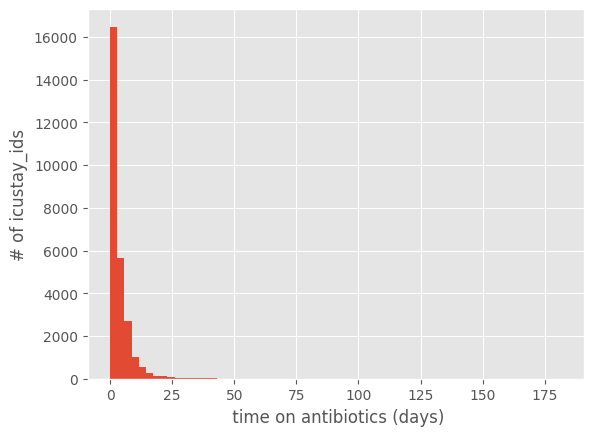

time: 312 ms (started: 2023-07-24 16:31:42 +08:00)


In [382]:
#i<20:
#all patients with appropriate antibiotic timing in relation to sterile culture. 
print(ABrx_ntnull_cohort2.drop_duplicates('stay_id')['abduration'].describe())

(ABrx_ntnull_cohort2.drop_duplicates('stay_id')['abduration'] / pd.Timedelta(days=1)).hist(bins = 63)#bins=xrange(min(compare_table['date delta']), 120, 1))
plt.xlabel(' time on antibiotics (days)')
plt.ylabel('# of icustay_ids');

# print(ABrx_ntnull_cohort2.drop_duplicates('stay_id').loc[ABrx_ntnull_cohort2.drop_duplicates('stay_id').loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
# print(ABrx_ntnull_cohort2.drop_duplicates('stay_id').loc[ABrx_ntnull_cohort2.drop_duplicates('stay_id').loc[:,'abduration']> pd.Timedelta(days=7),'abduration'].value_counts(bins=1))

In [383]:
ABrx_cohort_duration= ABrx_ntnull_cohort2[['stay_id','abduration','t_end_consec']].drop_duplicates('stay_id')

time: 0 ns (started: 2023-07-24 16:31:48 +08:00)


In [384]:
ABrx_cohort_duration.head()

,stay_id,abduration,t_end_consec
0,37435803,2 days 08:00:00,2182-09-12 19:00:00
2,39215891,0 days 09:00:00,2173-09-18 08:00:00
4,31026358,0 days 17:00:00,2119-11-23 10:00:00
11,32694603,0 days 02:00:00,2193-04-19 16:00:00
15,39721603,3 days 12:00:00,2165-02-05 18:00:00


time: 0 ns (started: 2023-07-24 16:31:50 +08:00)


In [385]:
#test
ABrx_cohort_duration.loc[ABrx_cohort_duration['abduration'] == '']
nullc = ABrx_cohort_duration['abduration'].isnull().sum()
nullc

0

time: 0 ns (started: 2023-07-24 16:31:53 +08:00)


In [386]:
#adding duration into ssc_t0ab_t0ssc
ssc_t0ab_t0ssc= pd.merge(ssc_t0ab_t0ssc,ABrx_cohort_duration, left_on='stay_id', right_on='stay_id', how='inner' ) #20451

time: 15 ms (started: 2023-07-24 16:32:10 +08:00)


In [387]:
ssc_t0ab_t0ssc

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,t_0_sc,abduration,t_end_consec
0,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00,2131-01-10 16:36:00,9 days 04:00:00,2131-01-20 12:00:00
1,33685454,2129-08-05 15:54:00,796,2129-08-04 12:45:00,14801473,2129-08-05 14:00:00,2129-08-10 13:00:00,-1 days +22:06:00,2129-08-05 14:00:00,2129-08-10 13:00:00,2129-08-05 15:54:00,10 days 19:00:00,2129-08-16 09:00:00
2,31090461,2130-09-25 11:04:00,822,2130-09-24 00:50:00,14801575,2130-09-25 11:00:00,2130-09-26 11:00:00,-1 days +23:56:00,2130-09-25 11:00:00,2130-09-26 11:00:00,2130-09-25 11:04:00,1 days 00:00:00,2130-09-26 11:00:00
3,32358465,2131-03-10 00:58:00,828,2131-03-09 21:33:00,14801420,2131-03-10 01:00:00,2131-03-10 14:00:00,0 days 00:02:00,2131-03-10 01:00:00,2131-03-10 14:00:00,2131-03-10 00:58:00,0 days 13:00:00,2131-03-10 14:00:00
4,38875437,2156-04-19 16:28:00,893,2156-04-19 18:11:19,14802091,2156-04-20 12:00:00,2156-04-21 11:00:00,0 days 19:32:00,2156-04-20 12:00:00,2156-04-21 11:00:00,2156-04-19 16:28:00,1 days 05:00:00,2156-04-21 17:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27215,35165301,2197-08-05 14:57:00,3228511,2197-08-04 00:02:00,14796608,2197-08-04 20:00:00,2197-08-12 11:00:00,-1 days +05:03:00,2197-08-04 20:00:00,2197-08-12 11:00:00,2197-08-05 14:57:00,7 days 15:00:00,2197-08-12 11:00:00
27216,37364566,2162-08-15 09:33:00,3228521,2162-08-16 05:48:32,14796834,2162-08-16 08:00:00,2162-08-17 12:00:00,0 days 22:27:00,2162-08-16 08:00:00,2162-08-17 12:00:00,2162-08-15 09:33:00,1 days 04:00:00,2162-08-17 12:00:00
27217,36075953,2149-01-08 20:00:00,3228661,2149-01-08 18:12:00,14798102,2149-01-08 20:00:00,2149-01-14 08:00:00,0 days 00:00:00,2149-01-08 20:00:00,2149-01-14 08:00:00,2149-01-08 20:00:00,5 days 12:00:00,2149-01-14 08:00:00
27218,38978960,2164-09-12 13:39:00,3228673,2164-09-12 09:26:28,14798283,2164-09-12 20:00:00,2164-09-16 12:00:00,0 days 06:21:00,2164-09-12 20:00:00,2164-09-16 12:00:00,2164-09-12 13:39:00,3 days 16:00:00,2164-09-16 12:00:00


time: 16 ms (started: 2023-07-24 16:32:12 +08:00)


# task 3, categorize every patient into ab bins
* group 1= partial= is antibiotics for 3 days or less
* group 2= full= is antibiotics for 5 or more days or died during ab course


### adding back in subject_id and adding DOD
we realized later on that we need dod in our spreadsheet. below adds it to our final patient set. 

In [389]:
#remaking a subject_id:icustay_id mapping (lost because i stripped this in the cartesian product between ab_join/ ssc_join)
#get patient list that we are working with
subject_id_mapping= sql_reimagined_16_df[['stay_id','subject_id']].drop_duplicates('stay_id')
subject_id_mapping= subject_id_mapping[subject_id_mapping['stay_id'].isin(ssc_t0ab_t0ssc['stay_id'].to_list())]

time: 32 ms (started: 2023-07-24 16:32:27 +08:00)


In [390]:
#mimic-iv only has dod

#task 3, dod
#issue: there is a differential on 155 ssd's. 

#(DOD_HOSP) or the social security database (DOD_SSN).

list_pt =subject_id_mapping['subject_id'].unique()
dod_sql = query_schema + """
SELECT subject_id, dod 
from mimiciv_hosp.patients
WHERE subject_id in {}
""".format(tuple(list_pt))     
dod_df = pd.read_sql_query(dod_sql,conn)

dod_df2= dod_df[dod_df['dod'].notnull()]
dod_df2.loc[dod_df2.loc[:,'dod']!= timedelta(days=0),:].head(5)

# dod_df['delta']= dod_df['dod_hosp']- dod_df['dod_ssn']
# #dod_df.loc[dod_df.loc[:,'delta'].notnull()!=timedelta(days=0),:]

# dod_df2= dod_df[dod_df['delta'].notnull()]
# dod_df2.loc[dod_df2.loc[:,'delta']!= timedelta(days=0),:].head(5)

C:\Users\csfhe\AppData\Local\Temp\ipykernel_9440\2456269746.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dod_df = pd.read_sql_query(dod_sql,conn)


,subject_id,dod
0,10001884,2131-01-20
1,10002155,2131-03-10
5,10003400,2137-09-02
8,10004401,2144-06-18
9,10004720,2186-11-17


time: 109 ms (started: 2023-07-24 16:32:30 +08:00)


In [391]:
dod_df.head()

,subject_id,dod
0,10001884,2131-01-20
1,10002155,2131-03-10
2,10002428,None
3,10002443,None
4,10002495,None


time: 16 ms (started: 2023-07-24 16:32:34 +08:00)


In [392]:
#adding in mapping between icustay_id : subject_id
ssc_t0ab_t0ssc = pd.merge(
    ssc_t0ab_t0ssc,
    subject_id_mapping,
    left_on= 'stay_id',
    right_on='stay_id',
    how = 'inner')

#adding in mapping between subject_id : dod from hospital and ssn
ssc_t0ab_t0ssc = pd.merge(
    ssc_t0ab_t0ssc,
    dod_df[['subject_id','dod']],
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

time: 32 ms (started: 2023-07-24 16:32:37 +08:00)


In [393]:
ssc_t0ab_t0ssc

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,t_0_sc,abduration,t_end_consec,subject_id,dod
0,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00,2131-01-10 16:36:00,9 days 04:00:00,2131-01-20 12:00:00,10001884,2131-01-20
1,33685454,2129-08-05 15:54:00,796,2129-08-04 12:45:00,14801473,2129-08-05 14:00:00,2129-08-10 13:00:00,-1 days +22:06:00,2129-08-05 14:00:00,2129-08-10 13:00:00,2129-08-05 15:54:00,10 days 19:00:00,2129-08-16 09:00:00,10002155,2131-03-10
2,31090461,2130-09-25 11:04:00,822,2130-09-24 00:50:00,14801575,2130-09-25 11:00:00,2130-09-26 11:00:00,-1 days +23:56:00,2130-09-25 11:00:00,2130-09-26 11:00:00,2130-09-25 11:04:00,1 days 00:00:00,2130-09-26 11:00:00,10002155,2131-03-10
3,32358465,2131-03-10 00:58:00,828,2131-03-09 21:33:00,14801420,2131-03-10 01:00:00,2131-03-10 14:00:00,0 days 00:02:00,2131-03-10 01:00:00,2131-03-10 14:00:00,2131-03-10 00:58:00,0 days 13:00:00,2131-03-10 14:00:00,10002155,2131-03-10
4,38875437,2156-04-19 16:28:00,893,2156-04-19 18:11:19,14802091,2156-04-20 12:00:00,2156-04-21 11:00:00,0 days 19:32:00,2156-04-20 12:00:00,2156-04-21 11:00:00,2156-04-19 16:28:00,1 days 05:00:00,2156-04-21 17:00:00,10002428,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27215,35165301,2197-08-05 14:57:00,3228511,2197-08-04 00:02:00,14796608,2197-08-04 20:00:00,2197-08-12 11:00:00,-1 days +05:03:00,2197-08-04 20:00:00,2197-08-12 11:00:00,2197-08-05 14:57:00,7 days 15:00:00,2197-08-12 11:00:00,19999287,2197-09-02
27216,37364566,2162-08-15 09:33:00,3228521,2162-08-16 05:48:32,14796834,2162-08-16 08:00:00,2162-08-17 12:00:00,0 days 22:27:00,2162-08-16 08:00:00,2162-08-17 12:00:00,2162-08-15 09:33:00,1 days 04:00:00,2162-08-17 12:00:00,19999297,2162-08-23
27217,36075953,2149-01-08 20:00:00,3228661,2149-01-08 18:12:00,14798102,2149-01-08 20:00:00,2149-01-14 08:00:00,0 days 00:00:00,2149-01-08 20:00:00,2149-01-14 08:00:00,2149-01-08 20:00:00,5 days 12:00:00,2149-01-14 08:00:00,19999828,None
27218,38978960,2164-09-12 13:39:00,3228673,2164-09-12 09:26:28,14798283,2164-09-12 20:00:00,2164-09-16 12:00:00,0 days 06:21:00,2164-09-12 20:00:00,2164-09-16 12:00:00,2164-09-12 13:39:00,3 days 16:00:00,2164-09-16 12:00:00,19999840,2164-09-17


time: 16 ms (started: 2023-07-24 16:32:42 +08:00)


In [421]:
ssc_t0ab_t0ssc['ab_course']=''

ssc_t0ab_t0ssc.loc[
    ssc_t0ab_t0ssc.loc[:,'abduration'] <= pd.Timedelta(days=4),'ab_course']='partial' #days changed from 3 to 4 on 7/16/18 based on Nelson's suggestion

ssc_t0ab_t0ssc.loc[
    ssc_t0ab_t0ssc.loc[:,'abduration'] > pd.Timedelta(days=4),'ab_course']='full'

ssc_t0ab_t0ssc.loc[
    ((pd.to_datetime(ssc_t0ab_t0ssc['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(ssc_t0ab_t0ssc['dod'])),
    'ab_course']='full'

# ssc_t0ab_t0ssc.loc[
#     ((pd.to_datetime(ssc_t0ab_t0ssc['t_end_consec'])+ pd.DateOffset(1)) 
#      >= pd.to_datetime(ssc_t0ab_t0ssc['dod_ssn'])),
#     'ab_course']='full'

time: 15 ms (started: 2023-07-24 16:38:44 +08:00)


In [422]:
print(len(
    ssc_t0ab_t0ssc.loc[
        ssc_t0ab_t0ssc.loc[:,'ab_course']=='full','subject_id'].unique())) #7044 iv
print(len(
    ssc_t0ab_t0ssc.loc[
        ssc_t0ab_t0ssc.loc[:,'ab_course']=='partial','subject_id'].unique())) #14794 iv


8196
14794
time: 16 ms (started: 2023-07-24 16:38:57 +08:00)


In [423]:
ssc_t0ab_t0ssc['stay_id'].nunique() #27220 iv

27220

time: 0 ns (started: 2023-07-24 16:39:10 +08:00)


# SC culture filtering and ab death dose adjust

In [424]:
# first need to restrict all ssc to parameters:

def SSC_for_cohort(#final_abdata_pt_df=ABrx_16sterile_ntnul_finalPT,
                   #ssc_ab_24_t0_tend=ssc_ab_24_t0_tend,
                   cohort_ssc_ab= ssc_ab_24_t0_tend,
                   blood_only=False,
                   n_days=3,
                   n_day_column='t_0_sc',
                   first_ssc_after_ICU=False,
                   filter_t0_after_ICU=False,
                   n_filter_days=4):
    """
    input: ABrx_16sterile_ntnul_finalPT: final by icustay df where the first ab prescription meeting the 24hr sc window is listed. 
    said another way, using the prescription antibiotic list and the list of dates of ssc cultures, building patient list that annotates first ab within 24 hr of sc for each pt. 
    
    ssc_sql: the primary sql query df for ssc info from mimic (default is to use sterile_pt_df)
  
    blood_only: option to restrict to only blood cultures
    
    n_days, n_day_column: the number of days after t_0 where SSC's will be considered to assign a patient as having a positive or negative.
    origionally the criteria was to find SSC cultures within a 3 days window of t_0 (first ab time) and t_0_sc (first ssc time), if any were pos then patient was culture pos, else negative.
    we can sepcify column (n_day_column) and day window if we want to look from ICU_admit instead.
    
    first_ssc_after_ICU: allows option to restrict the culture result output to only those after ICU admission. 
    filter_t0_after_ICU: allows option to restrict the first antibiotic (t_0) to only those after ICU admission. 
    n_filter_days: number of days allowed after ICU admit for an ab (t_0) to occur for patient to be considered, requires  filter_t0_after_ICU=True.
        
    outputs:
        ssc_t0sc_twindow: all (neg and pos) culture results for patients meeting criteria during n_filter_days
            ###notneg_cultures_pt_df_ab_cohort: just positive culture results for patients meeting criteria
            ###positive_organisms: all positive organisms found in ssc instances between t_0_sc and n_day_column. 
    """
    ####filtering criteria for all SSC results:######

    ssc_ab_24_t0_tend2=pd.merge(cohort_ssc_ab,
             sql_reimagined_16_df[['ssc_id','org_name','spec_type_desc','spec_itemid']],
             left_on='ssc_id',
             right_on='ssc_id',
            how='inner')

    #criteria1: only results at or after the first positive within 24 hr of t_0
    criteria1= ssc_ab_24_t0_tend2['ssc_charttime']>=ssc_ab_24_t0_tend2['t_0_sc'] #t_0_scis the first ssc within 24 hr of t_0

    #criteria2: only results within n_days of n_day_column
    t_window= pd.Timedelta('%s days' %(n_days))
    criteria2= (ssc_ab_24_t0_tend2['ssc_charttime'])<=(ssc_ab_24_t0_tend2[n_day_column]+ t_window) #ensure it's within n_days of n_day_column (default = culture_chartime, but can switch to t_admit)
    ssc_t0sc_twindow = ssc_ab_24_t0_tend2[criteria1 & criteria2].drop_duplicates(['stay_id', 'org_name', 'ssc_charttime'])
    
    return(ssc_t0sc_twindow)
    

time: 0 ns (started: 2023-07-24 16:39:13 +08:00)


In [425]:
from parameters import blood_only, n_days, n_day_column, first_ssc_after_ICU, filter_t0_after_ICU, n_filter_days

ssc_t0sc_twindow = SSC_for_cohort(blood_only=blood_only,
                                   n_days=n_days,
                                   n_day_column=n_day_column,
                                   first_ssc_after_ICU=first_ssc_after_ICU,
                                   filter_t0_after_ICU=filter_t0_after_ICU,
                                   n_filter_days=n_filter_days)

time: 156 ms (started: 2023-07-24 16:39:16 +08:00)


###  import the annotated culture list, exclude the excludes, and get an # of positives for the staphs.

08/16/18 qc. after chaning the patient criteira, i found that a lot of patients with multiple icustays now have identical culture results. need to explore where this is occuring.



In [426]:
#Dr. Nelson Sanchez-Pinto went through and individually checked all bacterial organisms in our SSC list and categorized them as either eliminate (negative) , staph, or keep (positive). 
# organisms in the positive list will be considered as a positive culture
# organisms in the negative list will be considered negative cultures
# organisms in the staph list requires 2 positives in same patient within the timewindow. 

negative_list=['CANDIDA (TORULOPSIS) GLABRATA',
 'YEAST',
 'CANDIDA ALBICANS',
 '2ND ISOLATE',
 'CANDIDA ALBICANS, PRESUMPTIVE IDENTIFICATION',
 'CANDIDA DUBLINIENSIS',
 'CANDIDA GUILLIERMONDII',
 'CANDIDA KEFYR',
 'CANDIDA KRUSEI / CANDIDA INCONSPICUA',
 'CANDIDA PARAPSILOSIS',
 'CANDIDA TROPICALIS',
 'CANDIDA LUSITANIAE',
 'CRYPTOCOCCUS NEOFORMANS',
 'CANCELLED',
 'YEAST, PRESUMPTIVELY NOT C. ALBICANS',
'CANDIDA KRUSEI'
'MOLD']

staph_list=['STAPHYLOCOCCUS EPIDERMIDIS',
 'STAPHYLOCOCCUS HOMINIS',
 'STAPHYLOCOCCUS LUGDUNENSIS',
 'STAPHYLOCOCCUS SAPROPHYTICUS, PRESUMPTIVE IDENTIFICATION',
 'STAPHYLOCOCCUS SPECIES',
 'STAPHYLOCOCCUS, COAGULASE NEGATIVE',
 'STAPHYLOCOCCUS, COAGULASE NEGATIVE, PRESUMPTIVELY NOT S. SAPROPHYTICUS']

positive_list=['ESCHERICHIA COLI',
 'KLEBSIELLA PNEUMONIAE',
 'STAPH AUREUS COAG +',
 'PROTEUS MIRABILIS',
 'ENTEROCOCCUS SP.',
 'PSEUDOMONAS AERUGINOSA',
 'ENTEROBACTER CLOACAE',
 'KLEBSIELLA OXYTOCA',
 'CITROBACTER FREUNDII COMPLEX',
 'ENTEROCOCCUS FAECIUM',
 'SERRATIA MARCESCENS',
 'ENTEROCOCCUS FAECALIS',
 'STREPTOCOCCUS PNEUMONIAE',
 'GRAM NEGATIVE ROD(S)',
 'GRAM POSITIVE BACTERIA',
 'CITROBACTER KOSERI',
 'MORGANELLA MORGANII',
 'VIRIDANS STREPTOCOCCI',
 'ENTEROBACTER AEROGENES',
 'PROVIDENCIA STUARTII',
 'BETA STREPTOCOCCUS GROUP B',
 'CORYNEBACTERIUM SPECIES (DIPHTHEROIDS)',
 'ENTEROBACTERIACEAE',
 'ACINETOBACTER BAUMANNII',
 'ENTEROBACTER CLOACAE COMPLEX',
 'HAFNIA ALVEI',
 'NON-FERMENTER, NOT PSEUDOMONAS AERUGINOSA',
 'STREPTOCOCCUS ANGINOSUS (MILLERI) GROUP',
 'GRAM POSITIVE COCCUS(COCCI)',
 'AEROMONAS SPECIES',
 'BACTEROIDES FRAGILIS GROUP',
 'PANTOEA SPECIES',
 'ACINETOBACTER BAUMANNII COMPLEX',
 'PROTEUS VULGARIS',
 'PROBABLE ENTEROCOCCUS',
 'LACTOBACILLUS SPECIES',
 'STENOTROPHOMONAS (XANTHOMONAS) MALTOPHILIA',
 'BETA STREPTOCOCCUS GROUP A',
 'CITROBACTER AMALONATICUS',
 'ENTEROBACTER GERGOVIAE',
 'STREPTOCOCCUS BOVIS ',
 'ALPHA STREPTOCOCCI',
 'PASTEURELLA MULTOCIDA',
 'ENTEROCOCCUS RAFFINOSUS',
 'ESCHERICHIA FERGUSONII',
 'ENTEROCOCCUS CASSELIFLAVUS',
 'GRAM NEGATIVE ROD #2',
 'PSEUDOMONAS LUTEOLA',
 'AEROMONAS HYDROPHILA',
 'PRESUMPTIVE STREPTOCOCCUS BOVIS',
 'PLESIOMONAS SHIGELLOIDES',
 'PSEUDOMONAS PUTIDA ',
 'BETA STREPTOCOCCUS GROUP C',
 'AEROMONAS HYDROPHILIA COMPLEX',
 'BETA STREPTOCOCCUS GROUP G',
 'GRAM POSITIVE RODS',
 'ENTEROBACTER SPECIES',
 'SERRATIA SPECIES',
 'PROVIDENCIA SPECIES',
 'PANTOEA (ENTEROBACTER) AGGLOMERANS',
 'CLOSTRIDIUM SPECIES NOT C. PERFRINGENS OR C. SEPTICUM',
 'STREPTOCOCCUS ANGINOSUS',
 'PRESUMPTIVE PEPTOSTREPTOCOCCUS SPECIES',
 'GRAM NEGATIVE ROD #1',
 'ACINETOBACTER SP.',
 'PRESUMPTIVE CLOSTRIDIUM PERFRINGENS',
 'ANAEROBIC GRAM POSITIVE ROD(S)',
 'PREVOTELLA SPECIES',
 'STREPTOCOCCUS MILLERI GROUP',
 'GAMMA(I.E. NON-HEMOLYTIC) STREPTOCOCCUS',
 'BURKHOLDERIA CEPACIA GROUP',
 'PRESUMPTIVE VEILLONELLA SPECIES',
 'PROTEUS SPECIES',
 'PRESUMPTIVE GARDNERELLA VAGINALIS',
 'FUSOBACTERIUM NUCLEATUM',
 'PROPIONIBACTERIUM ACNES',
 'ANAEROBIC GRAM POSITIVE COCCUS(I)',
 'PROBABLE MICROCOCCUS SPECIES',
 'PROBABLE GARDNERELLA VAGINALIS',
 'NUTRITIONALLY VARIANT STREPTOCOCCUS',
 'RESEMBLING MICROCOCCUS/STOMATOCOCCUS SPECIES',
 'CORYNEBACTERIUM STRIATUM',
 'CLOSTRIDIUM SPECIES',
 'ENTEROCOCCUS MUNDTII',
 'MICROCOCCUS/STOMATOCOCCUS SPECIES',
 'PRESUMPTIVE PROPIONIBACTERIUM ACNES',
 'LISTERIA MONOCYTOGENES',
 'BACTERIA',
 'BETA STREPTOCOCCUS',
 'ANAEROBIC GRAM NEGATIVE ROD(S)',
 'STREPTOCOCCUS SPECIES',
 'HAEMOPHILUS INFLUENZAE',
 'PRESUMPTIVE CLOSTRIDIUM SEPTICUM',
 'STREPTOCOCCUS CONSTELLATUS',
 'BACILLUS SPECIES',
 'HAEMOPHILUS SPECIES NOT INFLUENZAE',
 'BACILLUS SPECIES; NOT ANTHRACIS',
 'HAEMOPHILUS INFLUENZAE, BETA-LACTAMASE NEGATIVE',
 'GRAM VARIABLE RODS',
 'EIKENELLA CORRODENS',
 'NEISSERIA MENINGITIDIS',
 'PSEUDOMONAS SPECIES',
 'AEROCOCCUS SPECIES',
 'ABIOTROPHIA/GRANULICATELLA SPECIES',
 'GRAM NEGATIVE ROD #3',
 'ANAEROBIC GRAM NEGATIVE ROD #2',
 'BURKHOLDERIA (PSEUDOMONAS) CEPACIA',
 'FUSOBACTERIUM SPECIES',
 'CORYNEBACTERIUM UREALYTICUM SP. NOV.',
 'CAPNOCYTOPHAGA SPECIES',
 'GEMELLA SPECIES',
 'GEMELLA (STREPTOCOCCUS) MORBILLORUM',
 'NEISSERIA SPECIES',
 'MYCOBACTERIUM TUBERCULOSIS COMPLEX',
 'CAMPYLOBACTER SPECIES',
 'AEROCOCCUS VIRIDANS',
 'NOCARDIA FARCINICA',
 'STREPTOCOCCUS SALIVARIUS',
 'GRAM NEGATIVE ROD #4',
"HAEMOPHILUS INFLUENZAE, BETA-LACTAMASE POSITIVE",
'MORAXELLA CATARRHALIS',
'BETA STREPTOCOCCI, NOT GROUP A',
'STREPTOCOCCUS MILLERI',
'POSITIVE FOR PNEUMOCYSTIS JIROVECII (CARINII)',
'POSITIVE FOR PNEUMOCYSTIS CARINII   ',
               'VIRUS',
              ]


time: 15 ms (started: 2023-07-24 16:39:18 +08:00)


In [427]:
ssc_t0sc_twindow_notnull= ssc_t0sc_twindow[ssc_t0sc_twindow['org_name'].notnull()].copy()

time: 16 ms (started: 2023-07-24 16:39:25 +08:00)


In [428]:
ssc_t0sc_twindow_notnull.loc[ssc_t0sc_twindow_notnull['org_name'].isin(negative_list), 'Eliminate']=1
ssc_t0sc_twindow_notnull.loc[ssc_t0sc_twindow_notnull['org_name'].isin(staph_list), 'Eliminate']=2
ssc_t0sc_twindow_notnull.loc[ssc_t0sc_twindow_notnull['org_name'].isin(positive_list), 'Eliminate']=0
ssc_t0sc_twindow_notnull.loc[~ssc_t0sc_twindow_notnull['org_name'].isin(positive_list+negative_list+staph_list), 'Eliminate']=0 #for now
#ssc_t0sc_twindow.loc[ssc_t0sc_twindow['org_name'].isna(), 'Eliminate']=1 #for now

time: 0 ns (started: 2023-07-24 16:39:27 +08:00)


In [429]:
ssc_t0sc_twindow_notnull['Eliminate'].value_counts()
# Eliminate
# 0.0    5198
# 1.0    1416
# 2.0     496

Eliminate
0.0    5198
1.0    1416
2.0     496
Name: count, dtype: int64

time: 0 ns (started: 2023-07-24 16:39:28 +08:00)


In [430]:
##4-4-19: changed to the much cleaner version.
def sc_pos_filter(notneg_cultures_pt_df_ab_cohort):
    #coag_neg_staph_counting:
    staph_cultures= notneg_cultures_pt_df_ab_cohort.loc[notneg_cultures_pt_df_ab_cohort.loc[:,'Eliminate']==2,:].drop_duplicates(['stay_id', 'org_name', 'ssc_charttime'])

    staph_count = staph_cultures.groupby('stay_id')['stay_id'].agg(["count"]).rename(columns={'count': 'staph_count'})
    staph_count= pd.DataFrame(staph_count).reset_index()

    merged = pd.merge(
        notneg_cultures_pt_df_ab_cohort,
        staph_count, #changed  subject_id to hadm_id 08/16/2018
        left_on= 'stay_id', #changed  subject_id to hadm_id 08/16/2018
        right_on='stay_id', #changed  subject_id to hadm_id 08/16/2018
        how = 'left')

    #combining staph, positive org and neg org criteria to make only positive org list. 
    criteria1= merged.loc[:,'Eliminate']==0
    criteria2= merged.loc[:,'staph_count']>1
    merged= merged[criteria1|criteria2] #all unique values betwen the two
    merged= merged[merged['Eliminate']!=1] #eliminate =1 means to get rid of culture result, ie likely contamination
    #merged
    return(merged)

pos_cultures_pt_df_ab_cohort = sc_pos_filter(ssc_t0sc_twindow_notnull) #31108 #all pos sc for patients with any positives.

pos_cultures_pt_df_ab_cohort_list= list(pos_cultures_pt_df_ab_cohort['stay_id'].unique()) #changed to hadm_id 08/16/2018


time: 16 ms (started: 2023-07-24 16:39:30 +08:00)


In [431]:
pos_cultures_pt_df_ab_cohort.head()

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,t_0_sc,org_name,spec_type_desc,spec_itemid,Eliminate,staph_count
2,34577403,2137-08-10 14:54:00,1402,2137-08-10 19:54:51,14804355,2137-08-10 17:00:00,2137-08-11 16:00:00,0 days 02:06:00,2137-08-10 17:00:00,2137-08-11 16:00:00,2137-08-10 14:54:00,PSEUDOMONAS AERUGINOSA,URINE,70079,0.0,NaN
3,32773003,2144-01-27 03:26:00,1646,2144-01-26 22:28:04,14805925,2144-01-27 00:00:00,2144-01-27 11:00:00,-1 days +20:34:00,2144-01-27 00:00:00,2144-01-27 11:00:00,2144-01-27 03:26:00,PROTEUS MIRABILIS,URINE,70079,0.0,NaN
4,38292466,2144-04-06 08:25:00,1707,2144-04-05 10:57:00,14805428,2144-04-05 14:00:00,2144-04-09 12:00:00,-1 days +05:35:00,2144-04-05 14:00:00,2144-04-09 12:00:00,2144-04-06 08:25:00,STAPH AUREUS COAG +,BLOOD CULTURE,70012,0.0,NaN
5,39699336,2144-06-06 01:18:00,1847,2144-06-05 20:36:00,14805580,2144-06-05 22:00:00,2144-06-06 21:00:00,-1 days +20:42:00,2144-06-05 22:00:00,2144-06-06 21:00:00,2144-06-06 01:18:00,STAPH AUREUS COAG +,BLOOD CULTURE,70012,0.0,NaN
6,39699336,2144-06-06 03:45:00,1857,2144-06-05 20:36:00,14805580,2144-06-05 22:00:00,2144-06-06 21:00:00,-1 days +18:15:00,2144-06-05 22:00:00,2144-06-06 21:00:00,2144-06-06 01:18:00,KLEBSIELLA PNEUMONIAE,URINE,70079,0.0,NaN


time: 16 ms (started: 2023-07-24 16:39:33 +08:00)


In [432]:
len(pos_cultures_pt_df_ab_cohort)

5290

time: 0 ns (started: 2023-07-24 16:39:36 +08:00)


In [433]:
# final_pts_window_pos_sc.loc[final_pts_window_pos_sc.loc[:,'staph_pos_count']>2,:].head()
# #hadm_id 183885 has positive staph
pos_cultures_pt_df_ab_cohort.sort_values(['stay_id', 'org_name', 'ssc_charttime']).head(10)

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,t_0_sc,org_name,spec_type_desc,spec_itemid,Eliminate,staph_count
4659,30001446,2186-04-12 00:06:00,2105472,2186-04-12 03:49:00,9438865,2186-04-12 01:00:00,2186-04-12 02:00:00,0 days 00:54:00,2186-04-12 01:00:00,2186-04-12 02:00:00,2186-04-12 00:06:00,KLEBSIELLA PNEUMONIAE,URINE,70079,0.0,NaN
4660,30001446,2186-04-12 02:00:00,2105483,2186-04-12 03:49:00,9438865,2186-04-12 01:00:00,2186-04-12 02:00:00,-1 days +23:00:00,2186-04-12 01:00:00,2186-04-12 02:00:00,2186-04-12 00:06:00,KLEBSIELLA PNEUMONIAE,BLOOD CULTURE,70012,0.0,NaN
6183,30006983,2159-10-11 21:45:00,2823031,2159-10-12 03:56:42,12895675,2159-10-12 05:00:00,2159-10-13 04:00:00,0 days 07:15:00,2159-10-12 05:00:00,2159-10-13 04:00:00,2159-10-11 16:09:00,ESCHERICHIA COLI,BLOOD CULTURE,70012,0.0,NaN
6184,30006983,2159-10-12 19:20:00,2823063,2159-10-12 03:56:42,12895675,2159-10-12 05:00:00,2159-10-13 04:00:00,-1 days +09:40:00,2159-10-12 05:00:00,2159-10-13 04:00:00,2159-10-11 16:09:00,ESCHERICHIA COLI,BLOOD CULTURE,70012,0.0,NaN
4724,30016026,2168-02-16 10:06:00,2139882,2168-02-16 14:59:16,9605254,2168-02-16 17:00:00,2168-02-17 16:00:00,0 days 06:54:00,2168-02-16 17:00:00,2168-02-17 16:00:00,2168-02-16 10:06:00,GRAM NEGATIVE ROD(S),BRONCHOALVEOLAR LAVAGE,70021,0.0,NaN
4179,30019415,2134-06-15 13:39:00,1894516,2134-06-14 21:28:48,8402758,2134-06-15 02:00:00,2134-06-16 03:00:00,-1 days +12:21:00,2134-06-15 02:00:00,2134-06-16 03:00:00,2134-06-14 22:09:00,GRAM NEGATIVE ROD(S),URINE,70079,0.0,NaN
6241,30025405,2133-08-26 15:14:00,2857308,2133-08-26 07:10:58,13054331,2133-08-26 15:00:00,2133-08-30 21:00:00,-1 days +23:46:00,2133-08-26 15:00:00,2133-08-30 21:00:00,2133-08-26 15:14:00,PROTEUS MIRABILIS,URINE,70079,0.0,NaN
1592,30025720,2164-09-25 02:17:00,709321,2164-09-25 00:48:28,2750674,2164-09-25 02:00:00,2164-09-26 01:00:00,-1 days +23:43:00,2164-09-25 02:00:00,2164-09-26 01:00:00,2164-09-25 01:20:00,GRAM POSITIVE BACTERIA,URINE,70079,0.0,NaN
1591,30025720,2164-09-25 01:20:00,709317,2164-09-25 00:48:28,2750674,2164-09-25 02:00:00,2164-09-26 01:00:00,0 days 00:40:00,2164-09-25 02:00:00,2164-09-26 01:00:00,2164-09-25 01:20:00,STREPTOCOCCUS PNEUMONIAE,BLOOD CULTURE,70012,0.0,NaN
4406,30026004,2142-05-07 10:40:00,1998715,2142-05-05 16:22:27,8913446,2142-05-07 10:00:00,2142-05-09 09:00:00,-1 days +23:20:00,2142-05-07 10:00:00,2142-05-09 09:00:00,2142-05-07 10:40:00,ESCHERICHIA COLI,URINE,70079,0.0,NaN


time: 16 ms (started: 2023-07-24 16:39:37 +08:00)


### make list of all patients positive, negative sc cultures

In [434]:
pos_cultures_pt_df_ab_cohort

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,t_0_sc,org_name,spec_type_desc,spec_itemid,Eliminate,staph_count
2,34577403,2137-08-10 14:54:00,1402,2137-08-10 19:54:51,14804355,2137-08-10 17:00:00,2137-08-11 16:00:00,0 days 02:06:00,2137-08-10 17:00:00,2137-08-11 16:00:00,2137-08-10 14:54:00,PSEUDOMONAS AERUGINOSA,URINE,70079,0.0,NaN
3,32773003,2144-01-27 03:26:00,1646,2144-01-26 22:28:04,14805925,2144-01-27 00:00:00,2144-01-27 11:00:00,-1 days +20:34:00,2144-01-27 00:00:00,2144-01-27 11:00:00,2144-01-27 03:26:00,PROTEUS MIRABILIS,URINE,70079,0.0,NaN
4,38292466,2144-04-06 08:25:00,1707,2144-04-05 10:57:00,14805428,2144-04-05 14:00:00,2144-04-09 12:00:00,-1 days +05:35:00,2144-04-05 14:00:00,2144-04-09 12:00:00,2144-04-06 08:25:00,STAPH AUREUS COAG +,BLOOD CULTURE,70012,0.0,NaN
5,39699336,2144-06-06 01:18:00,1847,2144-06-05 20:36:00,14805580,2144-06-05 22:00:00,2144-06-06 21:00:00,-1 days +20:42:00,2144-06-05 22:00:00,2144-06-06 21:00:00,2144-06-06 01:18:00,STAPH AUREUS COAG +,BLOOD CULTURE,70012,0.0,NaN
6,39699336,2144-06-06 03:45:00,1857,2144-06-05 20:36:00,14805580,2144-06-05 22:00:00,2144-06-06 21:00:00,-1 days +18:15:00,2144-06-05 22:00:00,2144-06-06 21:00:00,2144-06-06 01:18:00,KLEBSIELLA PNEUMONIAE,URINE,70079,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7104,36005469,2130-10-07 11:57:00,3226560,2130-10-05 14:59:00,14784162,2130-10-07 19:00:00,2130-10-12 22:00:00,0 days 07:03:00,2130-10-07 19:00:00,2130-10-12 22:00:00,2130-10-07 11:57:00,GRAM POSITIVE BACTERIA,URINE,70079,0.0,NaN
7105,34670930,2126-10-19 12:05:00,3227782,2126-10-18 01:43:00,14791207,2126-10-20 11:00:00,2126-10-21 17:00:00,0 days 22:55:00,2126-10-20 11:00:00,2126-10-21 17:00:00,2126-10-19 12:05:00,ENTEROBACTER AEROGENES,BRONCHOALVEOLAR LAVAGE,70021,0.0,NaN
7106,36980198,2127-04-02 17:54:00,3228024,2127-04-02 12:46:56,14793300,2127-04-02 09:00:00,2127-04-02 13:00:00,-1 days +15:06:00,2127-04-02 09:00:00,2127-04-02 13:00:00,2127-04-02 17:54:00,PRESUMPTIVE STREPTOCOCCUS BOVIS,PLEURAL FLUID,70054,0.0,NaN
7108,37364566,2162-08-15 09:33:00,3228521,2162-08-16 05:48:32,14796834,2162-08-16 08:00:00,2162-08-17 12:00:00,0 days 22:27:00,2162-08-16 08:00:00,2162-08-17 12:00:00,2162-08-15 09:33:00,STAPH AUREUS COAG +,BLOOD CULTURE,70012,0.0,NaN


time: 31 ms (started: 2023-07-24 16:39:40 +08:00)


In [435]:
#organism name
pos_cultures_pt_df_ab_cohort3 = pos_cultures_pt_df_ab_cohort.groupby('stay_id')['org_name'].apply(', '.join).reset_index() #changed to hadm_id from subject_id 08/16/2018
pos_cultures_pt_df_ab_cohort3 = pos_cultures_pt_df_ab_cohort3.rename(index=str, columns={'org_name':'org_list'})

#specimen type
pos_cultures_pt_df_ab_cohort4 = pos_cultures_pt_df_ab_cohort.groupby('stay_id')['spec_type_desc'].apply(', '.join).reset_index() #changed to hadm_id from subject_id 08/16/2018
pos_cultures_pt_df_ab_cohort4 = pos_cultures_pt_df_ab_cohort4.rename(index=str, columns={'spec_type_desc':'spec_type_list'})


time: 188 ms (started: 2023-07-24 16:39:44 +08:00)


In [436]:
#first dates for positive culture within criteria window, else first culture within criteria window.
first_criteria_pos_culture= pos_cultures_pt_df_ab_cohort.groupby('stay_id')['ssc_charttime'].apply(lambda x: min(x)).reset_index()
first_criteria_any_culture= ssc_t0sc_twindow.groupby('stay_id')['ssc_charttime'].apply(lambda x: min(x)).reset_index()

first_criteria_pos_culture= first_criteria_pos_culture.rename(index=str, columns={'ssc_charttime':'pos_charttime'})
first_criteria_any_culture= pd.merge(first_criteria_any_culture, first_criteria_pos_culture, left_on='stay_id', right_on='stay_id', how='left')
first_criteria_any_culture['first_pos_else_neg_ssc']= first_criteria_any_culture['pos_charttime']
neg_else = first_criteria_any_culture['first_pos_else_neg_ssc'].isnull()
first_criteria_any_culture.loc[neg_else, 'first_pos_else_neg_ssc'] = first_criteria_any_culture.loc[neg_else, 'ssc_charttime']
first_criteria_any_culture=first_criteria_any_culture[['stay_id','first_pos_else_neg_ssc']]

time: 1.97 s (started: 2023-07-24 16:39:46 +08:00)


## this is final patient dataframe with n patients with following criteria:
* antibiotic in PRESCRIPTION table within 24 hours of an sterile site culture in MICROBIOLOGYEVENTS table
* who are over the age of 16. the culture result (annotated below) and antibiotic course (annotated below) are 
* also annotated on this. these patients were then categorized into 4 categories:
 * 'C_neg/A_partial'
 * 'C_neg/A_full'
 * 'C_pos/A_full'
 * 'C_pos/A_partial'
#### notes:
* 1)i considered any patient who had their last antibiotic date at or after either 
#hospital or ssn DOD as "full" ab course. 

* 2) i considered any patients who had the listed staph infections positive at 
#any of their sterile site cultures within the 72hour ab timewindow as a culture 'positive' patients. 

* 3) time window for positive culture is defined in SSC_for_cohort (default 72hr from t_0_sc)



In [437]:
final_pt_df= ssc_t0ab_t0ssc

final_pt_df = pd.merge(
    final_pt_df,
    pos_cultures_pt_df_ab_cohort3,
    left_on= 'stay_id', #changed to hadm_id from subject_id 08/16/18
    right_on='stay_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    pos_cultures_pt_df_ab_cohort4,
    left_on= 'stay_id', #changed to hadm_id from subject_id 08/16/18
    right_on='stay_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    first_criteria_any_culture,
    left_on= 'stay_id', #changed to hadm_id from subject_id 08/16/18
    right_on='stay_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

time: 32 ms (started: 2023-07-24 16:39:49 +08:00)


In [438]:
final_pt_df= final_pt_df.rename(index=str, columns={'delta':'dod'})
final_pt_df['sc_result']=''
final_pt_df['final_bin']=''

#task 1, marking of all patients positive, negative sc cultures
final_pt_df.loc[final_pt_df.loc[:,'stay_id'].isin(pos_cultures_pt_df_ab_cohort_list),'sc_result']='positive' #changed to hadm_id from subject_id 08/16/18
final_pt_df.loc[final_pt_df.loc[:,'sc_result']!='positive','sc_result']='negative'
#1 is positive, 0 is negative

#FINAL_PT_LIST=list(final_pt_df['subject_id'].unique())
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_partial'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_partial'

time: 47 ms (started: 2023-07-24 16:39:51 +08:00)


In [439]:
print(len(final_pt_df),
final_pt_df['stay_id'].nunique()
     )

27220 27220
time: 16 ms (started: 2023-07-24 16:39:53 +08:00)


In [440]:
final_pt_df

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,...,abduration,t_end_consec,subject_id,dod,ab_course,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result,final_bin
0,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00,...,9 days 04:00:00,2131-01-20 12:00:00,10001884,2131-01-20,full,NaN,NaN,2131-01-10 16:36:00,negative,C_neg/A_full
1,33685454,2129-08-05 15:54:00,796,2129-08-04 12:45:00,14801473,2129-08-05 14:00:00,2129-08-10 13:00:00,-1 days +22:06:00,2129-08-05 14:00:00,2129-08-10 13:00:00,...,10 days 19:00:00,2129-08-16 09:00:00,10002155,2131-03-10,full,NaN,NaN,2129-08-05 15:54:00,negative,C_neg/A_full
2,31090461,2130-09-25 11:04:00,822,2130-09-24 00:50:00,14801575,2130-09-25 11:00:00,2130-09-26 11:00:00,-1 days +23:56:00,2130-09-25 11:00:00,2130-09-26 11:00:00,...,1 days 00:00:00,2130-09-26 11:00:00,10002155,2131-03-10,partial,NaN,NaN,2130-09-25 11:04:00,negative,C_neg/A_partial
3,32358465,2131-03-10 00:58:00,828,2131-03-09 21:33:00,14801420,2131-03-10 01:00:00,2131-03-10 14:00:00,0 days 00:02:00,2131-03-10 01:00:00,2131-03-10 14:00:00,...,0 days 13:00:00,2131-03-10 14:00:00,10002155,2131-03-10,full,NaN,NaN,2131-03-10 00:58:00,negative,C_neg/A_full
4,38875437,2156-04-19 16:28:00,893,2156-04-19 18:11:19,14802091,2156-04-20 12:00:00,2156-04-21 11:00:00,0 days 19:32:00,2156-04-20 12:00:00,2156-04-21 11:00:00,...,1 days 05:00:00,2156-04-21 17:00:00,10002428,None,partial,NaN,NaN,2156-04-19 16:28:00,negative,C_neg/A_partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27215,35165301,2197-08-05 14:57:00,3228511,2197-08-04 00:02:00,14796608,2197-08-04 20:00:00,2197-08-12 11:00:00,-1 days +05:03:00,2197-08-04 20:00:00,2197-08-12 11:00:00,...,7 days 15:00:00,2197-08-12 11:00:00,19999287,2197-09-02,full,NaN,NaN,2197-08-05 14:57:00,negative,C_neg/A_full
27216,37364566,2162-08-15 09:33:00,3228521,2162-08-16 05:48:32,14796834,2162-08-16 08:00:00,2162-08-17 12:00:00,0 days 22:27:00,2162-08-16 08:00:00,2162-08-17 12:00:00,...,1 days 04:00:00,2162-08-17 12:00:00,19999297,2162-08-23,partial,STAPH AUREUS COAG +,BLOOD CULTURE,2162-08-15 09:33:00,positive,C_pos/A_partial
27217,36075953,2149-01-08 20:00:00,3228661,2149-01-08 18:12:00,14798102,2149-01-08 20:00:00,2149-01-14 08:00:00,0 days 00:00:00,2149-01-08 20:00:00,2149-01-14 08:00:00,...,5 days 12:00:00,2149-01-14 08:00:00,19999828,None,full,NaN,NaN,2149-01-08 20:00:00,negative,C_neg/A_full
27218,38978960,2164-09-12 13:39:00,3228673,2164-09-12 09:26:28,14798283,2164-09-12 20:00:00,2164-09-16 12:00:00,0 days 06:21:00,2164-09-12 20:00:00,2164-09-16 12:00:00,...,3 days 16:00:00,2164-09-16 12:00:00,19999840,2164-09-17,full,NaN,NaN,2164-09-12 13:39:00,negative,C_neg/A_full


time: 62 ms (started: 2023-07-24 16:39:54 +08:00)


In [441]:
final_pt_df.value_counts('final_bin')
# final_bin
# C_neg/A_partial    15150
# C_neg/A_full        7897
# C_pos/A_partial     2622
# C_pos/A_full        1551

final_bin
C_neg/A_partial    15150
C_neg/A_full        7897
C_pos/A_partial     2622
C_pos/A_full        1551
Name: count, dtype: int64

time: 0 ns (started: 2023-07-24 16:39:57 +08:00)


In [442]:
#test
final_pt_df.groupby('final_bin').count()

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,t_0_sc,abduration,t_end_consec,subject_id,dod,ab_course,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result
final_bin,,,,,,,,,,,,,,,,,,,,
C_neg/A_full,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,4871,7897,0,0,7897,7897
C_neg/A_partial,15150,15150,15150,15150,15150,15150,15150,15150,15150,15150,15150,15150,15150,15150,6336,15150,0,0,15150,15150
C_pos/A_full,1551,1551,1551,1551,1551,1551,1551,1551,1551,1551,1551,1551,1551,1551,1008,1551,1551,1551,1551,1551
C_pos/A_partial,2622,2622,2622,2622,2622,2622,2622,2622,2622,2622,2622,2622,2622,2622,1240,2622,2622,2622,2622,2622


time: 31 ms (started: 2023-07-24 16:39:59 +08:00)


In [443]:
#test
final_pt_df.loc[final_pt_df['final_bin'] == '']

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,...,abduration,t_end_consec,subject_id,dod,ab_course,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result,final_bin


time: 15 ms (started: 2023-07-24 16:40:00 +08:00)


In [444]:
final_pt_df['final_bin'].value_counts()*100/final_pt_df['stay_id'].nunique()

final_bin
C_neg/A_partial    55.657605
C_neg/A_full       29.011756
C_pos/A_partial     9.632623
C_pos/A_full        5.698016
Name: count, dtype: float64

time: 16 ms (started: 2023-07-24 16:40:34 +08:00)


# compiling the dataframes into csv's

In [446]:
date='07242023'
##adding in hadm_id
final_pt_df=pd.merge(final_pt_df, icustay_df[['stay_id','hadm_id']], left_on='stay_id',right_on='stay_id',how='inner')

from parameters import date
pd.DataFrame(final_pt_df).to_csv((str(repository_path)+ '/data/{}_final_pt_df.csv'.format(date)), index=False)


time: 1.45 s (started: 2023-07-24 16:41:22 +08:00)


In [ ]:

#admit_vs_t_0 ???
final_pt_df['admit_vs_t_0_td']=final_pt_df['admit_vs_t_0'].astype(np.timedelta64)

In [ ]:
final_pt_df.sort_values('admit_vs_t_0_td')
final_pt_df[final_pt_df2['admit_vs_t_0_td']<-1e+14].sort_values('admit_vs_t_0_td')['subject_id'].nunique() #3519/11488 patients have a delta of greater than 2 days of their icustay

1440

time: 13.2 ms


In [ ]:
##cohort numbers
s1={'n':(61532,38597,26020,14478),
    'labels': ('MIMICIII ICUStay_id', 'has SSC, >16yo','has ABrx', 'Final Study Criteria')#,
    #'subnum': ()
   }

pd.DataFrame(s1)

,n,labels
0,61532,MIMICIII ICUStay_id
1,38597,"has SSC, >16yo"
2,26020,has ABrx
3,14478,Final Study Criteria


time: 10.2 ms


##cohort numbers
-1	0	38597	purple	MIMICIII ICUstay_id
0	1	38597	purple	has SSC, >16yo
1	2	27315	purple	has ABrx
2	3	14478	purple	final
3	4	5723	green	C_neg/A_partial
3	5	2042	green	C_pos/A_full
3	6	5206	orange	C_neg/A_full
3	7	1507	orange	C_pos/A_partial